In [1]:
from os import listdir
from os.path import isfile, join
import pickle
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
sns.set_style("whitegrid", {"axes.grid": False})

In [2]:
base = 'OKE2016'

In [3]:
extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud','dandelion', 'dbspotlight', 'babelfy', 'textrazor']
extractors_types.sort()
extractors_disambiguation = ['dandelion', 'dbspotlight', 'babelfy', 'textrazor']
extractors_disambiguation.sort()

In [4]:
from sklearn.metrics import accuracy_score,f1_score

def evaluate_prediction(Y,standard_gold_list,predicted,uris_list_per_extractor_flatten,extractors_disambiguation_out):
    eval_obj = dict()
    uri_list=FromPreditedToURIs(predicted,uris_list_per_extractor_flatten,extractors_disambiguation_out)
    best_flatten = getBestResult(uris_list_per_extractor_flatten,standard_gold_list)
    eval_obj['score_disambiguation']=getScoresDisambiguation(standard_gold_list,uri_list)
    eval_obj['score_disambiguation_best']=getScoresDisambiguation(best_flatten,uri_list)
    predicted_round = predicted.round()
    uri_list_round = FromPreditedToURIs(predicted_round,uris_list_per_extractor_flatten,extractors_disambiguation_out)
    eval_obj['score_disambiguation_round']=getScoresDisambiguation(standard_gold_list,uri_list_round)
    eval_obj['score_disambiguation_best_round']=getScoresDisambiguation(best_flatten,uri_list_round)
    eval_obj['accuracy'] = accuracy_score(Y,predicted_round)
    eval_obj['f1_NN'] = dict()
    Y_t = np.transpose(Y)
    predicted_round_t = np.transpose(predicted_round)
    for i,ext in enumerate(extractors_disambiguation_out):
        eval_obj['f1_NN'][ext]=f1_score(Y_t[i],predicted_round_t[i])
    eval_obj['f1_NN']['weighted'] = np.mean([eval_obj['f1_NN'][ext] for ext in eval_obj['f1_NN']])
    return eval_obj


def FromPreditedToURIs(predicted,uris_list_per_extractor_flatten,rounding=False):
    extractors = list(uris_list_per_extractor_flatten[0].keys())
    extractors.sort()
    uri_list_end= list()
    if rounding:
        predicted = predicted.round()
    for k,line in enumerate(predicted):
        obj = uris_list_per_extractor_flatten[k]
        if len(set(line)) == 1 and line[0]==0:
            line = [1 for z in range(len(line))]
        line_dict = dict()
        for j,ext in enumerate(extractors):
            uri = obj[ext]
            if type(uri) == float:
                uri = '0'
            if uri in line_dict:
                line_dict[obj[ext]] += line[j]
            else:
                line_dict[obj[ext]] = line[j]
        #print(line_dict)
        selected = max(line_dict, key=line_dict.get)
        if selected == '0':
            selected = np.NAN
        uri_list_end.append(selected)
    return uri_list_end


def getScoresDisambiguation(standard_gold_list,predicted_list):
    true_negative = 0 
    true_positive = 0
    false_negative = 0
    false_positive = 0
    for i in range(len(standard_gold_list)):
        item_gold, item = standard_gold_list[i],predicted_list[i]
        if type(item_gold) != str and type(item) != str:
            true_negative += 1
        elif type(item_gold) == str and type(item) != str:
            false_negative += 1
        elif type(item_gold) != str and type(item) == str:
            false_positive += 1
        elif type(item_gold) == str and type(item) == str:
            if item == item_gold:
                true_positive += 1
            else:
                false_positive += 1
                false_negative += 1
    precision = true_positive / (true_positive+false_positive)
    recall = true_positive / (true_positive+false_negative)
    f1 = 2*(precision* recall)/(precision + recall)
    score_obj = {
        'precision':precision,
        'recall':recall,
        'f1':f1
    }
    return score_obj




def getUrisListPerFile(predicted,features_paths):
    uri_list_end= list()
    predicted_round = predicted.round()
    for j,f in enumerate(predicted_round):
        f_p = features_paths[j]
        uri_list_per_file= []
        obj = pickle.load(open(f_p,'rb'))
        uri_list = obj['uris_list']
        for k,line in enumerate(f[:len(uri_list['dandelion'])]):
            line_dict = dict()
            if 1 in line:
                for i,l in enumerate(line):
                    uri= obj['uris_list'][extractors_disambiguation[i]][k]
                    if type(uri) == float:
                        if '0' in line_dict: 
                            line_dict['0'] += l
                        else:
                            line_dict['0'] = l
                    else:  
                        if uri in line_dict: 
                            line_dict[uri] += l
                        else:
                            line_dict[uri] = l
                #print(line_dict)
                selected = max(line_dict, key=line_dict.get)
                if selected == '0':
                    selected = np.NAN
            else:
                selected = np.NAN
            uri_list_per_file.append(selected)
        uri_list_end.append(uri_list_per_file)
    return uri_list_end


def getURISListGT(groundtruth_paths):
    uris_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        uris = list()
        for r in recs_gt:
            uri = r['wd_uri']
            uris.append(uri)
        uris_df_per_file.append(uris)
    return uris_df_per_file

def getURISListPerExtractor(features_paths,extractor_list=['dandelion', 'dbspotlight', 'babelfy', 'textrazor']):
    uris_list_per_extractor = list()
    for j,f in enumerate(features_paths):
        uri_list_file = list()
        obj = pickle.load(open(f,'rb'))
        uri_list = obj['uris_list']
        uris_list_per_extractor.append([{ext:uri_list[ext][i] for ext in uri_list if ext in extractor_list} for i in range(len(uri_list['dandelion']))])
    return uris_list_per_extractor


def getURIListExt(features_paths,ext):
    uris_list_per_extractor = getURISListPerExtractor(features_paths,extractor_list=[ext])
    for i,f in enumerate(uris_list_per_extractor):
        for j,item in enumerate(f):
            uris_list_per_extractor[i][j] = item[ext]
    return uris_list_per_extractor
    

def getBestResult(uris_list_per_extractor_flatten,gt_test_flatten):
    best_result = list()
    for j,uri in enumerate(gt_test_flatten):
        if True in [uris_list_per_extractor_flatten[j][key]==uri for key in uris_list_per_extractor_flatten[j]]:
            best_result.append(uri)
        else:
            best_result.append(np.NAN)
    return best_result

def getTextList(groundtruth_paths):
    text_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        texts = list()
        for r in recs_gt:
            text = r['text']
            texts.append(text)
        text_df_per_file.append(texts)
    return text_df_per_file


def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file


def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTYPESListPerExtractor(features_paths,extractor_list=['alchemy', 'adel', 'opencalais', 'meaning_cloud','textrazor']):
    ext_dict_type = {ext:getTypeExtractor(ext,features_paths) for ext in extractor_list}
    type_list_per_exractor = list()
    for i in range(len(ext_dict_type[extractor_list[0]])):
        type_list_per_exractor_p = list()
        for j in range(len(ext_dict_type[extractor_list[0]][i])):
            type_list_per_exractor_p.append({ext:ext_dict_type[ext][i][j] for ext in extractor_list})
        type_list_per_exractor.append(type_list_per_exractor_p)
    return type_list_per_exractor


def isSameUri(wd1,wd2):
    return int((type(wd1)==type(wd2)==float) or (wd1==wd2))


def getDFEvaluation(uris_list_per_extractor_flatten,type_list_per_extractor_flatten,
                    gt_list_flatten_type,gt_list_flatten_uri,text_list_flatten):
    
    if not (len(uris_list_per_extractor_flatten) == len(type_list_per_extractor_flatten)
        == len(gt_list_flatten_uri) == len(gt_list_flatten_type) == len(text_list_flatten)):
        print(len(uris_list_per_extractor_flatten),len(type_list_per_extractor_flatten),
              len(gt_list_flatten_type),len(gt_list_flatten_uri),len(text_list_flatten))
        raise Exception
    len_ = len(gt_list_flatten_uri)
    records = list()
    for i in range(len_):
        rec = dict()
        rec['count_rights'] = 0
        rec['uri_GT'] = gt_list_flatten_uri[i]
        for key in uris_list_per_extractor_flatten[i]:
            rec['uri_'+key] = uris_list_per_extractor_flatten[i][key]
            rec['count_rights'] += int(rec['uri_GT']==rec['uri_'+key]) or (type(rec['uri_GT'])==type(rec['uri_'+key])==float)
        
        
     
        for key in type_list_per_extractor_flatten[i]:
            rec['type_'+key] = type_list_per_extractor_flatten[i][key]
        
        rec['type_GT'] = gt_list_flatten_type[i]
        
        rec['text'] = text_list_flatten[i]
        records.append(rec)
    df = pd.DataFrame(records)
    df = df.fillna(value='0')
    return df

def builtXY(uris_list_per_extractor_flatten,extractors_disambiguation_in,extractors_disambiguation,
            extractors_disambiguation_out,gt_flatten):
    X = []
    Y = []
    for i,line in enumerate(uris_list_per_extractor_flatten):
        X.append([isSameUri(line[key_1],line[key_2]) 
         for key_1 in extractors_disambiguation_in 
         for key_2 in extractors_disambiguation])
        Y.append([isSameUri(line[ext],gt_flatten[i])
                        for ext in extractors_disambiguation_out])

    X = np.array(X)
    Y = np.array(Y)
    return X,Y

def createModelObject(extractors_disambiguation_in,extractors_disambiguation,extractors_disambiguation_out,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test
                     ):
    model_obj = {
        'features_paths_train':features_paths_train,
        'features_paths_test':features_paths_test,
        'extractors_disambiguation_in':extractors_disambiguation_in,
        'extractors_disambiguation':extractors_disambiguation,
        'extractors_disambiguation_out':extractors_disambiguation_out
    }
    
    
    model_obj['train_X']= X_train
    model_obj['train_Y']= Y_train
    model_obj['train_GT']= gt_train_flatten
    model_obj['train_EXT']= uris_list_per_extractor_train_flatten
    model_obj['train_GT_best'] = getBestResult(uris_list_per_extractor_train_flatten,gt_train_flatten)
    model_obj['train_Y_best'] = builtXY(uris_list_per_extractor_train_flatten,extractors_disambiguation_in,
                                        extractors_disambiguation,extractors_disambiguation_out,model_obj['train_GT_best'])
    
    model_obj['test_X']= X_test
    model_obj['test_Y']= Y_test
    model_obj['test_GT']= gt_test_flatten
    model_obj['test_EXT']= uris_list_per_extractor_test_flatten
    model_obj['test_GT_best'] = getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)
    model_obj['test_Y_best'] = builtXY(uris_list_per_extractor_test_flatten,extractors_disambiguation_in,
                                        extractors_disambiguation,extractors_disambiguation_out,model_obj['test_GT_best'])
        
    
    return model_obj

def saveModelObj(model_obj,path):        
    pickle.dump( model_obj, open( path, "wb" ) )
def readModelObj(path):
    return pickle.load(open(path,'rb'))

In [5]:
training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

text_folder_train = training_folder + 'train/txt_files/'
text_folder_test = training_folder + 'test/txt_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()
features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()

texts_paths_train = [path.replace(features_folder_train,text_folder_train).replace('.p','.txt') for path in features_paths_train]
texts_paths_train.sort()
texts_paths_test = [path.replace(features_folder_test,text_folder_test).replace('.p','.txt') for path in features_paths_test]
texts_paths_test.sort()

texts_test = getTextList(groundtruth_paths_test)
texts_flatten_test = reduce(lambda x,y: x+y,texts_test)

texts_train = getTextList(groundtruth_paths_train)
texts_flatten_train = reduce(lambda x,y: x+y,texts_train)

In [6]:
gt_test = getURISListGT(groundtruth_paths_test)
gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
gt_train = getURISListGT(groundtruth_paths_train)
gt_train_flatten = reduce(lambda x,y: x+y,gt_train)

In [7]:
gt_test_type = getTypesListGT(groundtruth_paths_test)
gt_test_flatten_type = reduce(lambda x,y: x+y,gt_test)
gt_train_type = getTypesListGT(groundtruth_paths_train)
gt_train_flatten_type = reduce(lambda x,y: x+y,gt_train)

In [571]:
records_train = []
for ext in extractors_disambiguation:
    list_ext = getURIListExt(features_paths_train,ext)
    list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
    scores_disambiguation_obj = getScoresDisambiguation(gt_train_flatten,list_ext_flatten)
    scores_disambiguation_obj['extractor']=ext
    records_train.append(scores_disambiguation_obj)
    
df_eval_ext_train=pd.DataFrame(records_train)

writer = pd.ExcelWriter('disambiguation_images/extracors_scores_train.xlsx')
df_eval_ext_train.to_excel(writer)
writer.save()
display(df_eval_ext_train)



,extractor,f1,precision,recall
0,babelfy,0.610346,0.537300,0.706378
1,dandelion,0.566730,0.513434,0.632371
2,dbspotlight,0.386313,0.328553,0.468712
3,textrazor,0.689455,0.664804,0.716005


In [572]:
records_test = []
for ext in extractors_disambiguation:
    list_ext = getURIListExt(features_paths_test,ext)
    list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
    scores_disambiguation_obj = getScoresDisambiguation(gt_test_flatten,list_ext_flatten)
    scores_disambiguation_obj['extractor']=ext
    records_test.append(scores_disambiguation_obj)
    
df_eval_ext_test=pd.DataFrame(records_test)

writer = pd.ExcelWriter('disambiguation_images/extracors_scores_test.xlsx')
df_eval_ext_test.to_excel(writer)
writer.save()
display(df_eval_ext_test)

,extractor,f1,precision,recall
0,babelfy,0.524358,0.456790,0.615385
1,dandelion,0.523560,0.451128,0.623701
2,dbspotlight,0.393661,0.328691,0.490644
3,textrazor,0.668757,0.672269,0.665281


In [11]:
uris_list_per_extractor_train = getURISListPerExtractor(features_paths_train)
uris_list_per_extractor_train_flatten = reduce(lambda x,y: x+y,uris_list_per_extractor_train)
uris_list_per_extractor_test = getURISListPerExtractor(features_paths_test)
uris_list_per_extractor_test_flatten = reduce(lambda x,y: x+y,uris_list_per_extractor_test)

In [569]:
records_train = []
for ext in extractors_disambiguation:
    list_ext = getURIListExt(features_paths_train,ext)
    list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
    scores_disambiguation_obj = getScoresDisambiguation(getBestResult(uris_list_per_extractor_train_flatten,gt_train_flatten),list_ext_flatten)
    scores_disambiguation_obj['extractor']=ext
    records_train.append(scores_disambiguation_obj)
    
df_eval_ext_train=pd.DataFrame(records_train) 

writer = pd.ExcelWriter('disambiguation_images/extracors_scores_train_best.xlsx')
df_eval_ext_train.to_excel(writer)
writer.save()
display(df_eval_ext_train)

,extractor,f1,precision,recall
0,babelfy,0.653675,0.537300,0.834399
1,dandelion,0.608570,0.513434,0.746979
2,dbspotlight,0.412388,0.328553,0.553660
3,textrazor,0.744448,0.664804,0.845771


In [570]:

records_test = []
for ext in extractors_disambiguation:
    list_ext = getURIListExt(features_paths_test,ext)
    list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
    scores_disambiguation_obj = getScoresDisambiguation(getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten),list_ext_flatten)
    scores_disambiguation_obj['extractor']=ext
    records_test.append(scores_disambiguation_obj)
    
df_eval_ext_test=pd.DataFrame(records_test)

writer = pd.ExcelWriter('disambiguation_images/extracors_scores_test_best.xlsx')
df_eval_ext_test.to_excel(writer)
writer.save()
display(df_eval_ext_test)

,extractor,f1,precision,recall
0,babelfy,0.565966,0.456790,0.743719
1,dandelion,0.564440,0.451128,0.753769
2,dbspotlight,0.422939,0.328691,0.592965
3,textrazor,0.732265,0.672269,0.804020


In [8]:
type_list_per_extractor_train = getTYPESListPerExtractor(features_paths_train)
type_list_per_extractor_train_flatten = reduce(lambda x,y: x+y,type_list_per_extractor_train)

type_list_per_extractor_test = getURISListPerExtractor(features_paths_test)
type_list_per_extractor_test_flatten = reduce(lambda x,y: x+y,type_list_per_extractor_test)

In [15]:
df_eval_train = getDFEvaluation(uris_list_per_extractor_train_flatten,type_list_per_extractor_train_flatten,
                    gt_train_flatten_type,gt_train_flatten,texts_flatten_train)
    
df_eval_test = getDFEvaluation(uris_list_per_extractor_test_flatten,type_list_per_extractor_test_flatten,
                    gt_test_flatten_type,gt_test_flatten,texts_flatten_test)

In [17]:
def generateHistogram(x,ext_names,count_rights_names):
    colors = ['r','y','g','b','m']
    N = len(x)
    x = np.transpose(x)


    ind = np.arange(N)  # the x locations for the groups
    width = 0.2      # the width of the bars

    fig, ax = plt.subplots(figsize=(20,9))
    recs = [ax.bar(ind+width*i,tuple(x[i]), width, color=colors[i]) for i in range(len(ext_names))]
    

    # add some text for labels, title and axes ticks
    #ax.set_ylabel('Scores')
    #ax.set_title('Scores by extractor')
    #ax.set_xticks(ind + width)
    print(count_rights_names)
    ax.set_xticklabels(['','1','','2','','3','','4'])

    ax.legend(tuple([rec[0] for rec in recs]), tuple(ext_names))
    


    plt.show()

['1', '2', '3', '4']


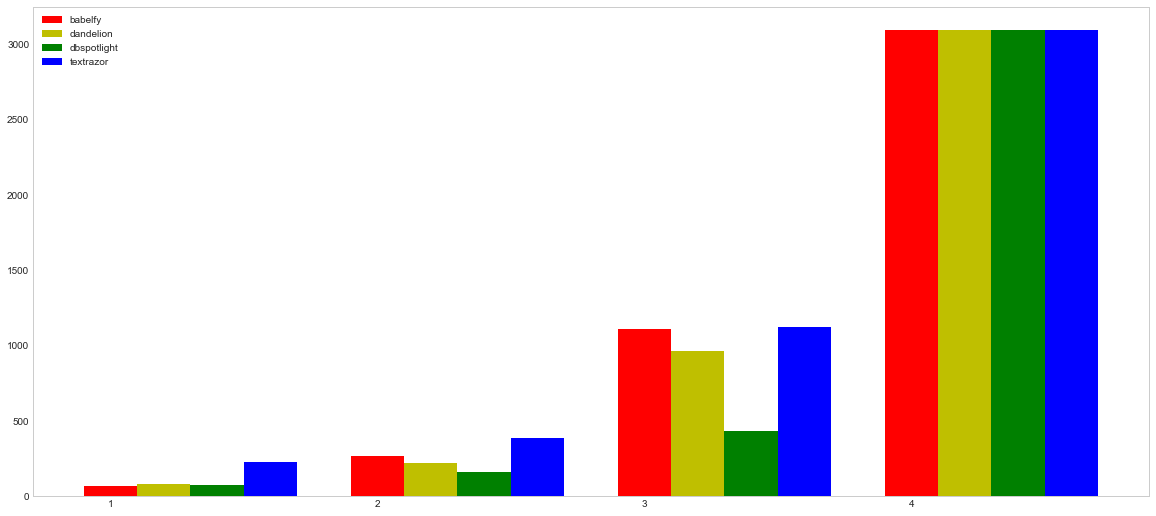

In [18]:
extractors = extractors_disambiguation
N = len(extractors)
count_rights_names = []
x = []
for i in range(1,N+1):
    x_p = []
    count_rights_names.append(str(i))
    for ext in extractors:
        val = len(df_eval_train[(df_eval_train['uri_GT']==df_eval_train['uri_'+ext])&(df_eval_train['count_rights']==i)])
        x_p.append(val)
    x.append(x_p)
generateHistogram(x,extractors,count_rights_names)


['1', '2', '3', '4']


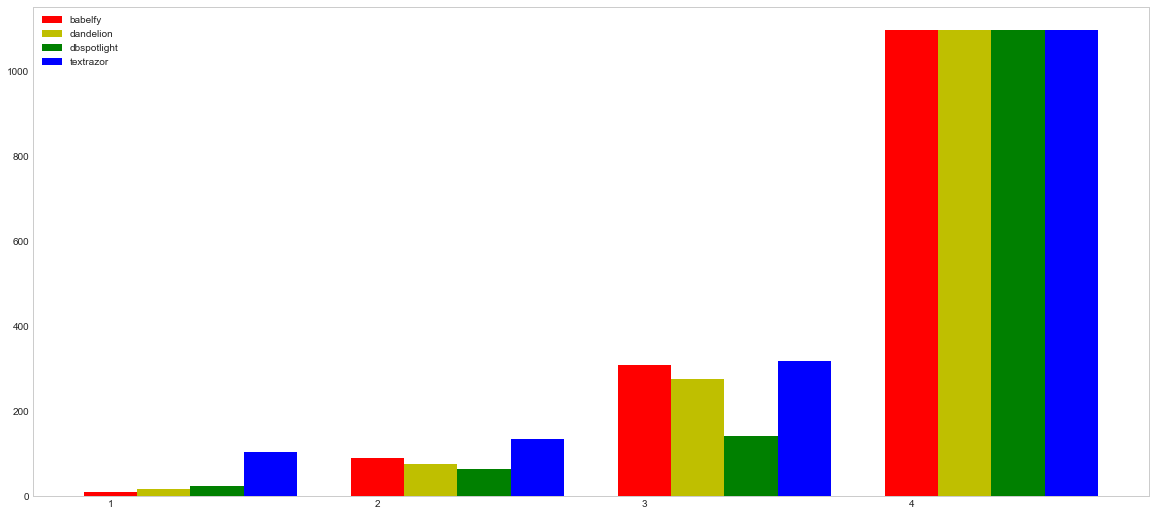

In [19]:
extractors = extractors_disambiguation
N = len(extractors)
count_rights_names = []
x = []
for i in range(1,N+1):
    x_p = []
    count_rights_names.append(str(i))
    for ext in extractors:
        val = len(df_eval_test[(df_eval_test['uri_GT']==df_eval_test['uri_'+ext])&(df_eval_test['count_rights']==i)])
        x_p.append(val)
    x.append(x_p)
generateHistogram(x,extractors,count_rights_names)

In [589]:
def getRelationshipExtractorDF_obj(uris_list_per_extractor_flatten,test_list,display_flag=True,paths=[None,None]):
    test_list_best = getBestResult(uris_list_per_extractor_flatten,test_list)
    ext_obj = {
        'GT':test_list,
        'GT_best':test_list_best
    }
    for key in uris_list_per_extractor_flatten[0]:
        ext_obj[key] = [l[key] for l in uris_list_per_extractor_flatten]
        ext_obj[key+'_best'] = getBestResult([{key:l[key]} for l in uris_list_per_extractor_flatten],test_list)
    ext_obj_rel = dict()
    correlation_matrix_1 = []
    correlation_matrix_2 = []
    names_1 = []
    names_2 = []
    for key_1 in ext_obj:
        records = list()
        correlation_matrix_1_p = []
        correlation_matrix_2_p = []
        for key_2 in ext_obj:
            obj = getScoresDisambiguation(ext_obj[key_2],ext_obj[key_1])
            obj['extractor'] = key_2
            records.append(obj)
            if 'best' in key_1 and not 'GT' in key_1 and 'best' in key_2 and 'GT' not in key_2:
                correlation_matrix_1_p.append(obj['f1'])
            if 'best' not in key_1 and not 'GT' in key_1 and 'best' not in key_2 and 'GT' not in key_2:
                correlation_matrix_2_p.append(obj['f1'])
        if 'best' in key_1 and not 'GT' in key_1:
            names_1.append(key_1)
        if 'best' not in key_1 and not 'GT' in key_1:
            names_2.append(key_1)
        if bool(correlation_matrix_1_p):
            correlation_matrix_1.append(correlation_matrix_1_p)
        if bool(correlation_matrix_2_p):
            correlation_matrix_2.append(correlation_matrix_2_p)
        ext_obj_rel[key_1]=pd.DataFrame(records)
    
    getHeatMap(correlation_matrix_1,names_1,paths[0])
    getHeatMap(correlation_matrix_2,names_2,paths[1])
    if display_flag:
        for key in ext_obj_rel:
            print(key)
            display(ext_obj_rel[key])
    
    return ext_obj_rel



In [577]:
def getHeatMap(correlation_matrix,names,path=None):
    np.random.seed(0)
    fig = plt.figure(figsize=(10,5))
    uniform_data = np.array(correlation_matrix)
    ax = sns.heatmap(uniform_data,xticklabels=names, yticklabels=names,center=0.5,annot=True,vmin=0, vmax=1, cmap="gray")
    ax.xaxis.tick_top()
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#999999')
    plt.yticks(rotation=0)
    plt.tight_layout()
    if bool(path):
        fig.savefig(path) 
    plt.show()

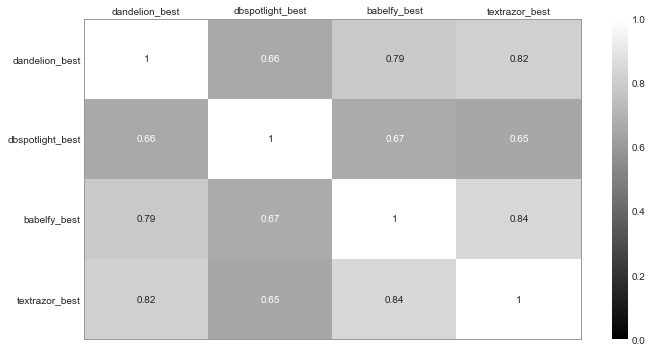

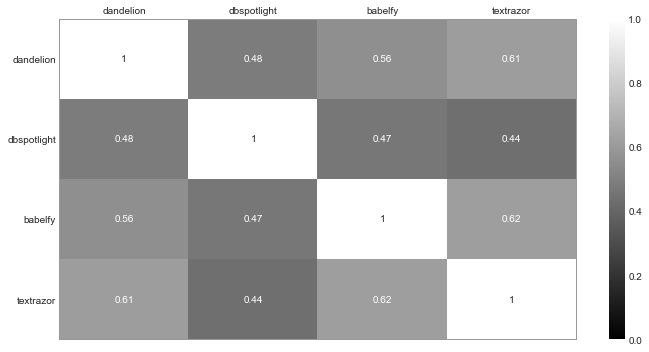

GT


,extractor,f1,precision,recall
0,GT,1.000000,1.000000,1.000000
1,GT_best,0.905575,0.827443,1.000000
2,dandelion,0.523560,0.623701,0.451128
3,dandelion_best,0.768246,0.623701,1.000000
4,dbspotlight,0.393661,0.490644,0.328691
5,dbspotlight_best,0.658298,0.490644,1.000000
6,babelfy,0.524358,0.615385,0.456790
7,babelfy_best,0.761905,0.615385,1.000000
8,textrazor,0.668757,0.665281,0.672269
9,textrazor_best,0.799001,0.665281,1.000000


GT_best


,extractor,f1,precision,recall
0,GT,0.905575,1.000000,0.827443
1,GT_best,1.000000,1.000000,1.000000
2,dandelion,0.564440,0.753769,0.451128
3,dandelion_best,0.859599,0.753769,1.000000
4,dbspotlight,0.422939,0.592965,0.328691
5,dbspotlight_best,0.744479,0.592965,1.000000
6,babelfy,0.565966,0.743719,0.456790
7,babelfy_best,0.853026,0.743719,1.000000
8,textrazor,0.732265,0.804020,0.672269
9,textrazor_best,0.891365,0.804020,1.000000


dandelion


,extractor,f1,precision,recall
0,GT,0.523560,0.451128,0.623701
1,GT_best,0.564440,0.451128,0.753769
2,dandelion,1.000000,1.000000,1.000000
3,dandelion_best,0.621762,0.451128,1.000000
4,dbspotlight,0.484454,0.503759,0.466574
5,dbspotlight_best,0.392897,0.266165,0.750000
6,babelfy,0.559025,0.551880,0.566358
7,babelfy_best,0.489074,0.353383,0.793919
8,textrazor,0.613497,0.526316,0.735294
9,textrazor_best,0.513706,0.380451,0.790625


dandelion_best


,extractor,f1,precision,recall
0,GT,0.768246,1.000000,0.623701
1,GT_best,0.859599,1.000000,0.753769
2,dandelion,0.621762,1.000000,0.451128
3,dandelion_best,1.000000,1.000000,1.000000
4,dbspotlight,0.347741,0.590000,0.246518
5,dbspotlight_best,0.660448,0.590000,0.750000
6,babelfy,0.495781,0.783333,0.362654
7,babelfy_best,0.788591,0.783333,0.793919
8,textrazor,0.652062,0.843333,0.531513
9,textrazor_best,0.816129,0.843333,0.790625


dbspotlight


,extractor,f1,precision,recall
0,GT,0.393661,0.328691,0.490644
1,GT_best,0.422939,0.328691,0.592965
2,dandelion,0.484454,0.466574,0.503759
3,dandelion_best,0.347741,0.246518,0.590000
4,dbspotlight,1.000000,1.000000,1.000000
5,dbspotlight_best,0.494759,0.328691,1.000000
6,babelfy,0.467057,0.444290,0.492284
7,babelfy_best,0.351085,0.247911,0.601351
8,textrazor,0.435511,0.362117,0.546218
9,textrazor_best,0.350674,0.253482,0.568750


dbspotlight_best


,extractor,f1,precision,recall
0,GT,0.658298,1.000000,0.490644
1,GT_best,0.744479,1.000000,0.592965
2,dandelion,0.392897,0.750000,0.266165
3,dandelion_best,0.660448,0.750000,0.590000
4,dbspotlight,0.494759,1.000000,0.328691
5,dbspotlight_best,1.000000,1.000000,1.000000
6,babelfy,0.402715,0.754237,0.274691
7,babelfy_best,0.669173,0.754237,0.601351
8,textrazor,0.511236,0.771186,0.382353
9,textrazor_best,0.654676,0.771186,0.568750


babelfy


,extractor,f1,precision,recall
0,GT,0.524358,0.456790,0.615385
1,GT_best,0.565966,0.456790,0.743719
2,dandelion,0.559025,0.566358,0.551880
3,dandelion_best,0.495781,0.362654,0.783333
4,dbspotlight,0.467057,0.492284,0.444290
5,dbspotlight_best,0.402715,0.274691,0.754237
6,babelfy,1.000000,1.000000,1.000000
7,babelfy_best,0.627119,0.456790,1.000000
8,textrazor,0.620996,0.538580,0.733193
9,textrazor_best,0.535124,0.399691,0.809375


babelfy_best


,extractor,f1,precision,recall
0,GT,0.761905,1.000000,0.615385
1,GT_best,0.853026,1.000000,0.743719
2,dandelion,0.489074,0.793919,0.353383
3,dandelion_best,0.788591,0.793919,0.783333
4,dbspotlight,0.351085,0.601351,0.247911
5,dbspotlight_best,0.669173,0.601351,0.754237
6,babelfy,0.627119,1.000000,0.456790
7,babelfy_best,1.000000,1.000000,1.000000
8,textrazor,0.670984,0.875000,0.544118
9,textrazor_best,0.840909,0.875000,0.809375


textrazor


,extractor,f1,precision,recall
0,GT,0.668757,0.672269,0.665281
1,GT_best,0.732265,0.672269,0.804020
2,dandelion,0.613497,0.735294,0.526316
3,dandelion_best,0.652062,0.531513,0.843333
4,dbspotlight,0.435511,0.546218,0.362117
5,dbspotlight_best,0.511236,0.382353,0.771186
6,babelfy,0.620996,0.733193,0.538580
7,babelfy_best,0.670984,0.544118,0.875000
8,textrazor,1.000000,1.000000,1.000000
9,textrazor_best,0.804020,0.672269,1.000000


textrazor_best


,extractor,f1,precision,recall
0,GT,0.799001,1.000000,0.665281
1,GT_best,0.891365,1.000000,0.804020
2,dandelion,0.513706,0.790625,0.380451
3,dandelion_best,0.816129,0.790625,0.843333
4,dbspotlight,0.350674,0.568750,0.253482
5,dbspotlight_best,0.654676,0.568750,0.771186
6,babelfy,0.535124,0.809375,0.399691
7,babelfy_best,0.840909,0.809375,0.875000
8,textrazor,0.804020,1.000000,0.672269
9,textrazor_best,1.000000,1.000000,1.000000


In [58]:
ext_obj_rel_test = getRelationshipExtractorDF_obj(uris_list_per_extractor_test_flatten,gt_test_flatten,display_flag=True,paths=[None,None])

In [127]:
X_train,Y_train = builtXY(uris_list_per_extractor_train_flatten,extractors_disambiguation,extractors_disambiguation,extractors_disambiguation,gt_train_flatten)

In [128]:
X_test,Y_test = builtXY(uris_list_per_extractor_test_flatten,extractors_disambiguation,extractors_disambiguation,extractors_disambiguation,gt_test_flatten)

In [129]:
extractors_disambiguation_in = ['textrazor']
extractors_disambiguation_out = ['textrazor']

In [141]:
model_obj = createModelObject(extractors_disambiguation,extractors_disambiguation,['textrazor','babelfy'],
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test
                     )

In [136]:
!mkdir disambiguation_models

mkdir: disambiguation_models: File exists


In [142]:
saveModelObj(model_obj,'disambiguation_models/1.p')

In [122]:
X_train_textrazor,Y_train_textrazor = builtXY(uris_list_per_extractor_train_flatten,['textrazor'],extractors_disambiguation,['textrazor'],gt_train_flatten)
X_test_textrazor,Y_test_textrazor = builtXY(uris_list_per_extractor_test_flatten,['textrazor'],extractors_disambiguation,['textrazor'],gt_test_flatten)

model_obj = createModelObject(['textrazor'],extractors_disambiguation,['textrazor'],
                      X_test_textrazor,X_train_textrazor,Y_test_textrazor,Y_train_textrazor,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test
                     )

saveModelObj(model_obj,'disambiguation_models/2.p')

In [144]:
!python3 NN_disambiguation_small.py --input_file disambiguation_models/1.p --layers 0 --patience 200

Using TensorFlow backend.
disambiguation_models/1.p
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________
None
Train on 5807 samples, validate on 1944 samples
Epoch 1/1000
2017-12-14 16:00:28.876433: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-14 16:00:28.876452: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed 

5807/5807 [==============================] - 0s - loss: 0.1239 - mean_absolute_error: 0.2749 - acc: 0.0226 - val_loss: 0.1167 - val_mean_absolute_error: 0.2650 - val_acc: 0.0242
Epoch 10/1000
5807/5807 [==============================] - 0s - loss: 0.1210 - mean_absolute_error: 0.2685 - acc: 0.0622 - val_loss: 0.1140 - val_mean_absolute_error: 0.2597 - val_acc: 0.0242
Epoch 11/1000
5807/5807 [==============================] - 0s - loss: 0.1186 - mean_absolute_error: 0.2635 - acc: 0.4851 - val_loss: 0.1118 - val_mean_absolute_error: 0.2547 - val_acc: 0.6286
Epoch 12/1000
5807/5807 [==============================] - 0s - loss: 0.1168 - mean_absolute_error: 0.2584 - acc: 0.4665 - val_loss: 0.1099 - val_mean_absolute_error: 0.2496 - val_acc: 0.6286
Epoch 13/1000
5807/5807 [==============================] - 0s - loss: 0.1152 - mean_absolute_error: 0.2541 - acc: 0.6017 - val_loss: 0.1084 - val_mean_absolute_error: 0.2472 - val_acc: 0.6286
Epoch 14/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1106 - mean_absolute_error: 0.2396 - acc: 0.6034 - val_loss: 0.1038 - val_mean_absolute_error: 0.2318 - val_acc: 0.6286
Epoch 19/1000
5807/5807 [==============================] - 0s - loss: 0.1100 - mean_absolute_error: 0.2364 - acc: 0.6058 - val_loss: 0.1032 - val_mean_absolute_error: 0.2304 - val_acc: 0.6353
Epoch 20/1000
5807/5807 [==============================] - 0s - loss: 0.1096 - mean_absolute_error: 0.2352 - acc: 0.6070 - val_loss: 0.1027 - val_mean_absolute_error: 0.2280 - val_acc: 0.6353
Epoch 21/1000
5807/5807 [==============================] - 0s - loss: 0.1092 - mean_absolute_error: 0.2336 - acc: 0.6070 - val_loss: 0.1024 - val_mean_absolute_error: 0.2276 - val_acc: 0.6353
Epoch 22/1000
5807/5807 [==============================] - 0s - loss: 0.1088 - mean_absolute_error: 0.2328 - acc: 0.6070 - val_loss: 0.1020 - val_mean_absolute_error: 0.2247 - val_acc: 0.6353
Epoch 23/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1078 - mean_absolute_error: 0.2243 - acc: 0.6070 - val_loss: 0.1010 - val_mean_absolute_error: 0.2193 - val_acc: 0.6353
Epoch 28/1000
5807/5807 [==============================] - 0s - loss: 0.1077 - mean_absolute_error: 0.2248 - acc: 0.6070 - val_loss: 0.1008 - val_mean_absolute_error: 0.2174 - val_acc: 0.6353
Epoch 29/1000
5807/5807 [==============================] - 0s - loss: 0.1076 - mean_absolute_error: 0.2226 - acc: 0.6070 - val_loss: 0.1007 - val_mean_absolute_error: 0.2186 - val_acc: 0.6353
Epoch 30/1000
5807/5807 [==============================] - 0s - loss: 0.1075 - mean_absolute_error: 0.2226 - acc: 0.6070 - val_loss: 0.1005 - val_mean_absolute_error: 0.2171 - val_acc: 0.6353
Epoch 31/1000
5807/5807 [==============================] - 0s - loss: 0.1074 - mean_absolute_error: 0.2228 - acc: 0.6070 - val_loss: 0.1004 - val_mean_absolute_error: 0.2150 - val_acc: 0.6353
Epoch 32/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1072 - mean_absolute_error: 0.2186 - acc: 0.6070 - val_loss: 0.1003 - val_mean_absolute_error: 0.2142 - val_acc: 0.6353
Epoch 37/1000
5807/5807 [==============================] - 0s - loss: 0.1071 - mean_absolute_error: 0.2191 - acc: 0.6070 - val_loss: 0.1002 - val_mean_absolute_error: 0.2137 - val_acc: 0.6353
Epoch 38/1000
5807/5807 [==============================] - 0s - loss: 0.1071 - mean_absolute_error: 0.2181 - acc: 0.6070 - val_loss: 0.1002 - val_mean_absolute_error: 0.2124 - val_acc: 0.6353
Epoch 39/1000
5807/5807 [==============================] - 0s - loss: 0.1071 - mean_absolute_error: 0.2174 - acc: 0.6070 - val_loss: 0.1001 - val_mean_absolute_error: 0.2132 - val_acc: 0.6353
Epoch 40/1000
5807/5807 [==============================] - 0s - loss: 0.1071 - mean_absolute_error: 0.2185 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2111 - val_acc: 0.6353
Epoch 41/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2163 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2105 - val_acc: 0.6353
Epoch 46/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.1001 - val_mean_absolute_error: 0.2122 - val_acc: 0.6353
Epoch 47/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2185 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2089 - val_acc: 0.6353
Epoch 48/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2110 - val_acc: 0.6353
Epoch 49/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2170 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 50/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6070 - val_loss: 0.1001 - val_mean_absolute_error: 0.2121 - val_acc: 0.6353
Epoch 55/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.1001 - val_mean_absolute_error: 0.2122 - val_acc: 0.6353
Epoch 56/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2173 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2082 - val_acc: 0.6353
Epoch 57/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2111 - val_acc: 0.6353
Epoch 58/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.1001 - val_mean_absolute_error: 0.2131 - val_acc: 0.6353
Epoch 59/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2160 - acc: 0.6112 - val_loss: 0.0999 - val_mean_absolute_error: 0.2086 - val_acc: 0.6353
Epoch 64/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2104 - val_acc: 0.6353
Epoch 65/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 66/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2156 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2106 - val_acc: 0.6353
Epoch 67/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2116 - val_acc: 0.6353
Epoch 68/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2157 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2099 - val_acc: 0.6353
Epoch 73/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2158 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2088 - val_acc: 0.6353
Epoch 74/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2135 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2102 - val_acc: 0.6353
Epoch 75/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2164 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2109 - val_acc: 0.6353
Epoch 76/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2088 - val_acc: 0.6353
Epoch 77/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2157 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2087 - val_acc: 0.6353
Epoch 82/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 83/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2077 - val_acc: 0.6353
Epoch 84/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2099 - val_acc: 0.6353
Epoch 85/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2156 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2088 - val_acc: 0.6353
Epoch 86/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 91/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 92/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2141 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 93/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2153 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2110 - val_acc: 0.6353
Epoch 94/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2106 - val_acc: 0.6353
Epoch 95/1000
5807/5807 [=============================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2095 - val_acc: 0.6353
Epoch 100/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2152 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2080 - val_acc: 0.6353
Epoch 101/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2159 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2086 - val_acc: 0.6353
Epoch 102/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2060 - val_acc: 0.6353
Epoch 103/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2139 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2085 - val_acc: 0.6353
Epoch 104/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2153 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2076 - val_acc: 0.6353
Epoch 109/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2141 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 110/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 111/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2105 - val_acc: 0.6353
Epoch 112/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2156 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2082 - val_acc: 0.6353
Epoch 113/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2088 - val_acc: 0.6353
Epoch 118/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2087 - val_acc: 0.6353
Epoch 119/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2086 - val_acc: 0.6353
Epoch 120/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2128 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2109 - val_acc: 0.6353
Epoch 121/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2161 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2109 - val_acc: 0.6353
Epoch 122/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2162 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2085 - val_acc: 0.6353
Epoch 127/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2152 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 128/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 129/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2106 - val_acc: 0.6353
Epoch 130/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2153 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 131/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2090 - val_acc: 0.6353
Epoch 136/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2139 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2093 - val_acc: 0.6353
Epoch 137/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2078 - val_acc: 0.6353
Epoch 138/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2130 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2100 - val_acc: 0.6353
Epoch 139/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2143 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2086 - val_acc: 0.6353
Epoch 140/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2087 - val_acc: 0.6353
Epoch 145/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6082 - val_loss: 0.1000 - val_mean_absolute_error: 0.2102 - val_acc: 0.6353
Epoch 146/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2161 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2086 - val_acc: 0.6353
Epoch 147/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2145 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 148/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2102 - val_acc: 0.6353
Epoch 149/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 154/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2096 - val_acc: 0.6353
Epoch 155/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2102 - val_acc: 0.6353
Epoch 156/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2143 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2115 - val_acc: 0.6353
Epoch 157/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2160 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2074 - val_acc: 0.6353
Epoch 158/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2108 - val_acc: 0.6353
Epoch 163/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2101 - val_acc: 0.6353
Epoch 164/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2113 - val_acc: 0.6353
Epoch 165/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2107 - val_acc: 0.6353
Epoch 166/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2158 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2081 - val_acc: 0.6353
Epoch 167/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2104 - val_acc: 0.6353
Epoch 172/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 173/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2100 - val_acc: 0.6353
Epoch 174/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 175/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2085 - val_acc: 0.6353
Epoch 176/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 181/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2159 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 182/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2078 - val_acc: 0.6353
Epoch 183/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2087 - val_acc: 0.6353
Epoch 184/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2079 - val_acc: 0.6353
Epoch 185/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2110 - val_acc: 0.6353
Epoch 190/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2157 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2095 - val_acc: 0.6353
Epoch 191/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2099 - val_acc: 0.6353
Epoch 192/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 193/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2098 - val_acc: 0.6353
Epoch 194/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2162 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2089 - val_acc: 0.6353
Epoch 199/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 200/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2139 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 201/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2152 - acc: 0.6103 - val_loss: 0.0999 - val_mean_absolute_error: 0.2093 - val_acc: 0.6353
Epoch 202/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2161 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2074 - val_acc: 0.6353
Epoch 203/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 208/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 209/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2163 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2098 - val_acc: 0.6353
Epoch 210/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2098 - val_acc: 0.6353
Epoch 211/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2161 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2078 - val_acc: 0.6353
Epoch 212/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2088 - val_acc: 0.6353
Epoch 217/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2089 - val_acc: 0.6353
Epoch 218/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2108 - val_acc: 0.6353
Epoch 219/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2077 - val_acc: 0.6353
Epoch 220/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2141 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2107 - val_acc: 0.6353
Epoch 221/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2095 - val_acc: 0.6353
Epoch 226/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2081 - val_acc: 0.6353
Epoch 227/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2100 - val_acc: 0.6353
Epoch 228/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2153 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2086 - val_acc: 0.6353
Epoch 229/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2134 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 230/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2093 - val_acc: 0.6353
Epoch 235/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2089 - val_acc: 0.6353
Epoch 236/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2145 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 237/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2161 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 238/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2077 - val_acc: 0.6353
Epoch 239/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2089 - val_acc: 0.6353
Epoch 244/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6129 - val_loss: 0.0998 - val_mean_absolute_error: 0.2078 - val_acc: 0.6353
Epoch 245/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2132 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 246/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2088 - val_acc: 0.6353
Epoch 247/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 248/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 253/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2096 - val_acc: 0.6353
Epoch 254/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2118 - val_acc: 0.6353
Epoch 255/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2163 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 256/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 257/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2152 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2096 - val_acc: 0.6353
Epoch 262/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2099 - val_acc: 0.6353
Epoch 263/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 264/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2163 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2082 - val_acc: 0.6353
Epoch 265/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 266/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2156 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2073 - val_acc: 0.6353
Epoch 271/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2135 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2099 - val_acc: 0.6353
Epoch 272/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2145 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2089 - val_acc: 0.6353
Epoch 273/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2098 - val_acc: 0.6353
Epoch 274/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 275/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2105 - val_acc: 0.6353
Epoch 280/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2100 - val_acc: 0.6353
Epoch 281/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 282/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2099 - val_acc: 0.6353
Epoch 283/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2163 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2065 - val_acc: 0.6353
Epoch 284/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2153 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2089 - val_acc: 0.6353
Epoch 289/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 290/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2101 - val_acc: 0.6353
Epoch 291/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2153 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2108 - val_acc: 0.6353
Epoch 292/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2165 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2078 - val_acc: 0.6353
Epoch 293/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2158 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2079 - val_acc: 0.6353
Epoch 298/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2145 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2073 - val_acc: 0.6353
Epoch 299/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2134 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 300/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2143 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 301/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2090 - val_acc: 0.6353
Epoch 302/1000
1944/1944 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2160 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2077 - val_acc: 0.6353
Epoch 307/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2141 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2086 - val_acc: 0.6353
Epoch 308/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2081 - val_acc: 0.6353
Epoch 309/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2141 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2098 - val_acc: 0.6353
Epoch 310/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 311/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2139 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2091 - val_acc: 0.6353
Epoch 316/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2093 - val_acc: 0.6353
Epoch 317/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2101 - val_acc: 0.6353
Epoch 318/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2145 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2105 - val_acc: 0.6353
Epoch 319/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2159 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 320/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2143 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2101 - val_acc: 0.6353
Epoch 325/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2102 - val_acc: 0.6353
Epoch 326/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6093 - val_loss: 0.0999 - val_mean_absolute_error: 0.2102 - val_acc: 0.6353
Epoch 327/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2158 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2087 - val_acc: 0.6353
Epoch 328/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2109 - val_acc: 0.6353
Epoch 329/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2143 - acc: 0.6096 - val_loss: 0.0999 - val_mean_absolute_error: 0.2095 - val_acc: 0.6353
Epoch 334/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2143 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2100 - val_acc: 0.6353
Epoch 335/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2080 - val_acc: 0.6353
Epoch 336/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2145 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 337/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2141 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2105 - val_acc: 0.6353
Epoch 338/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2110 - val_acc: 0.6353
Epoch 343/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2158 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2083 - val_acc: 0.6353
Epoch 344/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2157 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2083 - val_acc: 0.6353
Epoch 345/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2137 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2093 - val_acc: 0.6353
Epoch 346/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2164 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2090 - val_acc: 0.6353
Epoch 347/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2081 - val_acc: 0.6353
Epoch 352/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2078 - val_acc: 0.6353
Epoch 353/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2092 - val_acc: 0.6353
Epoch 354/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2082 - val_acc: 0.6353
Epoch 355/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2139 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2098 - val_acc: 0.6353
Epoch 356/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2132 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 361/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 362/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2170 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 363/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2145 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 364/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2158 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2085 - val_acc: 0.6353
Epoch 365/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2090 - val_acc: 0.6353
Epoch 370/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2144 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2108 - val_acc: 0.6353
Epoch 371/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2157 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2068 - val_acc: 0.6353
Epoch 372/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2126 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 373/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2090 - val_acc: 0.6353
Epoch 374/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2150 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2102 - val_acc: 0.6353
Epoch 379/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2147 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2101 - val_acc: 0.6353
Epoch 380/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2149 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2080 - val_acc: 0.6353
Epoch 381/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 382/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2156 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2099 - val_acc: 0.6353
Epoch 383/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2085 - val_acc: 0.6353
Epoch 388/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 389/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2153 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 390/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2155 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2097 - val_acc: 0.6353
Epoch 391/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2076 - val_acc: 0.6353
Epoch 392/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2142 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2103 - val_acc: 0.6353
Epoch 397/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0998 - val_mean_absolute_error: 0.2093 - val_acc: 0.6353
Epoch 398/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2084 - val_acc: 0.6353
Epoch 399/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2078 - val_acc: 0.6353
Epoch 400/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2143 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2076 - val_acc: 0.6353
Epoch 401/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2146 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2094 - val_acc: 0.6353
Epoch 406/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2154 - acc: 0.6070 - val_loss: 0.0999 - val_mean_absolute_error: 0.2081 - val_acc: 0.6353
Epoch 407/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2134 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2096 - val_acc: 0.6353
Epoch 408/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2148 - acc: 0.6070 - val_loss: 0.1001 - val_mean_absolute_error: 0.2105 - val_acc: 0.6353
Epoch 409/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2095 - val_acc: 0.6353
Epoch 410/1000
5807/5807 [========================

5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2140 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2112 - val_acc: 0.6353
Epoch 415/1000
5807/5807 [==============================] - 0s - loss: 0.1070 - mean_absolute_error: 0.2151 - acc: 0.6070 - val_loss: 0.1000 - val_mean_absolute_error: 0.2087 - val_acc: 0.6353


In [9]:
def createModelObject_b(extractors_disambiguation,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     ):
    model_obj = {
        'features_paths_train':features_paths_train,
        'features_paths_test':features_paths_test,
        'extractors_disambiguation':extractors_disambiguation
    }
    
    model_obj['candidates_train'] = candidates_train
    model_obj['candidates_test'] = candidates_test
    model_obj['train_X']= np.array(X_train)
    model_obj['train_Y']= np.array(Y_train)
    model_obj['train_GT']= gt_train_flatten
    model_obj['train_EXT']= uris_list_per_extractor_train_flatten
    model_obj['train_GT_best'] = getBestResult(uris_list_per_extractor_train_flatten,gt_train_flatten)
    model_obj['train_Y_best'] = builtXY_b(uris_list_per_extractor_train_flatten,extractors_disambiguation,model_obj['train_GT_best'])
    model_obj['test_X']= np.array(X_test)
    model_obj['test_Y']= np.array(Y_test)
    model_obj['test_GT']= gt_test_flatten
    model_obj['test_EXT']= uris_list_per_extractor_test_flatten
    model_obj['test_GT_best'] = getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)
    model_obj['test_Y_best'] = builtXY_b(uris_list_per_extractor_test_flatten,extractors_disambiguation,model_obj['test_GT_best'])
    
    
    return model_obj

def ConcatenateArray(list_arrays):
    array = list()
    for l in list_arrays:
        array += l
    return array

def builtXY_b(uris_list_per_extractor_flatten,extractors_disambiguation,gt_flatten):
    X = []
    Y = []
    candidates_list = []
    for i,line in enumerate(uris_list_per_extractor_flatten):
        
        candidates = set([line[ext] for ext in extractors_disambiguation if type(line[ext])==str])
        if True in [type(line[ext]) == float for ext in extractors_disambiguation]:
            candidates.add(np.NAN)
        candidates = list(candidates)
        candidates.sort(key=lambda x:str(x))
        X_p = [ConcatenateArray([[isSameUri(line[ext_1],uri)] for ext_1 in extractors_disambiguation])
               for uri in candidates]
        Y_p = [[isSameUri(uri,gt_flatten[i])]
               for uri in candidates]
        candidates_list.append(candidates)
        X += X_p
        Y += Y_p
    #X = np.array(X)
    Y = np.array(Y)
    return X,Y,candidates_list




def builtXY_b_complete(uris_list_per_extractor_flatten,extractors_disambiguation,gt_flatten,similarities_dict):
    X = []
    Y = []
    candidates_list = []
    for i,line in enumerate(uris_list_per_extractor_flatten):
        candidates = set([line[ext] for ext in extractors_disambiguation if type(line[ext])==str])
        if True in [type(line[ext]) == float for ext in extractors_disambiguation]:
            candidates.add(np.NAN)
        candidates = list(candidates)
        candidates.sort(key=lambda x:str(x))
        X_p = [ConcatenateArray([similarities_dict[(str(line[ext_1]),str(uri))] for ext_1 in extractors_disambiguation])
               for uri in candidates]
        Y_p = [[isSameUri(uri,gt_flatten[i])]
               for uri in candidates]
        candidates_list.append(candidates)
        X += X_p
        Y += Y_p
    X = np.array(X)
    Y = np.array(Y)
    return X,Y,candidates_list

def get_similarities_dict(features_paths_train,features_paths_test):
    sim_dict = dict()
    features_paths = features_paths_train+features_paths_test
    for i,f in enumerate(features_paths):
        similarites = pickle.load(open(f,'rb'))['features']['uris_MATRIX']
        for item in similarites.items():
            sim_dict[(str(item[0][0]),str(item[0][1]))] = item[1]
            sim_dict[(str(item[0][1]),str(item[0][0]))] = item[1]
    return sim_dict

def getLISTPREDICTED(P,candidates):
    count = 0
    list_uris = []
    for item in candidates:
        pred_obj = {}
        for uri in item:
            pred_obj[uri] = P[count][0]
            count += 1
        if 1 in [round(v) for v in list(pred_obj.values())]:
            selected = max(pred_obj, key=pred_obj.get)
        else:
            selected = np.NAN
        list_uris.append(selected)
    return list_uris

def evaluate_prediction_b(P,Y,candidates,standard_gold_list,uris_list_per_extractor_flatten):
    eval_obj = dict()
    uri_list = getLISTPREDICTED(P,candidates)
    best_flatten = getBestResult(uris_list_per_extractor_flatten,standard_gold_list)
    eval_obj['score_disambiguation']=getScoresDisambiguation(standard_gold_list,uri_list)
    eval_obj['score_disambiguation_best']=getScoresDisambiguation(best_flatten,uri_list)
    eval_obj['accuracy'] = accuracy_score(np.squeeze(Y),np.squeeze(P).round())
    eval_obj['f1_NN'] = f1_score(np.squeeze(Y),np.squeeze(P).round())
    return eval_obj

In [481]:
similarities_dict = get_similarities_dict(features_paths_train,features_paths_test)

In [600]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 0.85714286,  0.675     ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [603]:
model_obj_1['train_X'] == X_train

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [612]:
#ONLY URIs EQUAL, all extractors

X_train,Y_train,candidates_train = builtXY_b(uris_list_per_extractor_train_flatten,extractors_disambiguation,gt_train_flatten)
X_test,Y_test,candidates_test = builtXY_b(uris_list_per_extractor_test_flatten,extractors_disambiguation,gt_test_flatten)

model_obj_1 = createModelObject_b(extractors_disambiguation,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     )
saveModelObj(model_obj_1,'disambiguation_models/3.p')
!python3 NN_disambiguation_small2.py --input_file disambiguation_models/3.p --layers 1 --activation_middle selu --batch 250
model_obj = pickle.load(open('disambiguation_models/3.p','rb'))
P = model_obj['predicted_test']
uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
print(getScoresDisambiguation(gt_test_flatten,uri_list))

print(getScoresDisambiguation(gt_test_flatten_best,uri_list))

Using TensorFlow backend.
disambiguation_models/3.p
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               2000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
None
Train on 8981 samples, validate on 2930 samples
Epoch 1/1000
2017-12-16 18:38:56.536719: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but the

8981/8981 [==============================] - 0s - loss: 0.1154 - mean_absolute_error: 0.2315 - acc: 0.8433 - val_loss: 0.1111 - val_mean_absolute_error: 0.2290 - val_acc: 0.8355
Epoch 41/1000
8981/8981 [==============================] - 0s - loss: 0.1158 - mean_absolute_error: 0.2304 - acc: 0.8400 - val_loss: 0.1105 - val_mean_absolute_error: 0.2226 - val_acc: 0.8505
Epoch 42/1000
8981/8981 [==============================] - 0s - loss: 0.1161 - mean_absolute_error: 0.2309 - acc: 0.8419 - val_loss: 0.1106 - val_mean_absolute_error: 0.2302 - val_acc: 0.8416
Epoch 43/1000
8981/8981 [==============================] - 0s - loss: 0.1161 - mean_absolute_error: 0.2324 - acc: 0.8394 - val_loss: 0.1109 - val_mean_absolute_error: 0.2336 - val_acc: 0.8396
Epoch 44/1000
8981/8981 [==============================] - 0s - loss: 0.1154 - mean_absolute_error: 0.2312 - acc: 0.8432 - val_loss: 0.1106 - val_mean_absolute_error: 0.2263 - val_acc: 0.8355
Epoch 45/1000
8981/8981 [=============================

8981/8981 [==============================] - 0s - loss: 0.1155 - mean_absolute_error: 0.2312 - acc: 0.8432 - val_loss: 0.1105 - val_mean_absolute_error: 0.2286 - val_acc: 0.8355
Epoch 64/1000
8981/8981 [==============================] - 0s - loss: 0.1155 - mean_absolute_error: 0.2305 - acc: 0.8424 - val_loss: 0.1110 - val_mean_absolute_error: 0.2320 - val_acc: 0.8334
Epoch 65/1000
8981/8981 [==============================] - 0s - loss: 0.1155 - mean_absolute_error: 0.2315 - acc: 0.8394 - val_loss: 0.1109 - val_mean_absolute_error: 0.2320 - val_acc: 0.8355
Epoch 66/1000
8981/8981 [==============================] - 0s - loss: 0.1153 - mean_absolute_error: 0.2300 - acc: 0.8426 - val_loss: 0.1106 - val_mean_absolute_error: 0.2270 - val_acc: 0.8505
Epoch 67/1000
8981/8981 [==============================] - 0s - loss: 0.1155 - mean_absolute_error: 0.2313 - acc: 0.8406 - val_loss: 0.1107 - val_mean_absolute_error: 0.2324 - val_acc: 0.8355
Epoch 68/1000
8981/8981 [=============================

8981/8981 [==============================] - 0s - loss: 0.1152 - mean_absolute_error: 0.2302 - acc: 0.8418 - val_loss: 0.1110 - val_mean_absolute_error: 0.2309 - val_acc: 0.8334
Epoch 108/1000
8981/8981 [==============================] - 0s - loss: 0.1154 - mean_absolute_error: 0.2314 - acc: 0.8402 - val_loss: 0.1101 - val_mean_absolute_error: 0.2291 - val_acc: 0.8505
Epoch 109/1000
8981/8981 [==============================] - 0s - loss: 0.1154 - mean_absolute_error: 0.2298 - acc: 0.8408 - val_loss: 0.1104 - val_mean_absolute_error: 0.2266 - val_acc: 0.8505
Epoch 110/1000
8981/8981 [==============================] - 0s - loss: 0.1154 - mean_absolute_error: 0.2308 - acc: 0.8419 - val_loss: 0.1106 - val_mean_absolute_error: 0.2253 - val_acc: 0.8355
Epoch 111/1000
8981/8981 [==============================] - 0s - loss: 0.1152 - mean_absolute_error: 0.2319 - acc: 0.8428 - val_loss: 0.1106 - val_mean_absolute_error: 0.2323 - val_acc: 0.8416
Epoch 112/1000
8981/8981 [========================

8981/8981 [==============================] - 0s - loss: 0.1153 - mean_absolute_error: 0.2319 - acc: 0.8424 - val_loss: 0.1107 - val_mean_absolute_error: 0.2309 - val_acc: 0.8355
Epoch 153/1000
8981/8981 [==============================] - 0s - loss: 0.1153 - mean_absolute_error: 0.2307 - acc: 0.8417 - val_loss: 0.1106 - val_mean_absolute_error: 0.2293 - val_acc: 0.8355
Epoch 154/1000
8981/8981 [==============================] - 0s - loss: 0.1150 - mean_absolute_error: 0.2292 - acc: 0.8421 - val_loss: 0.1107 - val_mean_absolute_error: 0.2282 - val_acc: 0.8355
Epoch 155/1000
8981/8981 [==============================] - 0s - loss: 0.1157 - mean_absolute_error: 0.2293 - acc: 0.8401 - val_loss: 0.1103 - val_mean_absolute_error: 0.2299 - val_acc: 0.8416
Epoch 156/1000
8981/8981 [==============================] - 0s - loss: 0.1153 - mean_absolute_error: 0.2315 - acc: 0.8408 - val_loss: 0.1109 - val_mean_absolute_error: 0.2257 - val_acc: 0.8355
Epoch 157/1000
8981/8981 [========================

In [614]:
#ONLY URIs EQUAL, not TEXTRAZOR
similarities_dict = get_similarities_dict(features_paths_train,features_paths_test)
X_train,Y_train,candidates_train = builtXY_b(uris_list_per_extractor_train_flatten,['babelfy', 'dandelion', 'dbspotlight','textrazor'],gt_train_flatten)
X_test,Y_test,candidates_test = builtXY_b(uris_list_per_extractor_test_flatten,['babelfy', 'dandelion', 'dbspotlight','textrazor'],gt_test_flatten)

model_obj_1 = createModelObject_b(['babelfy', 'dandelion', 'dbspotlight'],
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     )
saveModelObj(model_obj_1,'disambiguation_models/4.p')

!python3 NN_disambiguation_small2.py --input_file disambiguation_models/4.p --layers 1 --activation_middle selu --batch 250

model_obj = pickle.load(open('disambiguation_models/4.p','rb'))
P = model_obj['predicted_test']
uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
print(getScoresDisambiguation(gt_test_flatten,uri_list))

print(getScoresDisambiguation(gt_test_flatten_best,uri_list))

Using TensorFlow backend.
disambiguation_models/4.p
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               2000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
None
Train on 8981 samples, validate on 2930 samples
Epoch 1/1000
2017-12-16 18:42:34.627526: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but the

8981/8981 [==============================] - 0s - loss: 0.1162 - mean_absolute_error: 0.2317 - acc: 0.8408 - val_loss: 0.1106 - val_mean_absolute_error: 0.2240 - val_acc: 0.8505
Epoch 41/1000
8981/8981 [==============================] - 0s - loss: 0.1158 - mean_absolute_error: 0.2290 - acc: 0.8416 - val_loss: 0.1106 - val_mean_absolute_error: 0.2285 - val_acc: 0.8355
Epoch 42/1000
8981/8981 [==============================] - 0s - loss: 0.1156 - mean_absolute_error: 0.2318 - acc: 0.8414 - val_loss: 0.1109 - val_mean_absolute_error: 0.2305 - val_acc: 0.8355
Epoch 43/1000
8981/8981 [==============================] - 0s - loss: 0.1157 - mean_absolute_error: 0.2306 - acc: 0.8407 - val_loss: 0.1115 - val_mean_absolute_error: 0.2213 - val_acc: 0.8505
Epoch 44/1000
8981/8981 [==============================] - 0s - loss: 0.1155 - mean_absolute_error: 0.2315 - acc: 0.8440 - val_loss: 0.1106 - val_mean_absolute_error: 0.2275 - val_acc: 0.8355
Epoch 45/1000
8981/8981 [=============================

8981/8981 [==============================] - 0s - loss: 0.1155 - mean_absolute_error: 0.2309 - acc: 0.8417 - val_loss: 0.1104 - val_mean_absolute_error: 0.2296 - val_acc: 0.8355
Epoch 86/1000
8981/8981 [==============================] - 0s - loss: 0.1153 - mean_absolute_error: 0.2304 - acc: 0.8416 - val_loss: 0.1107 - val_mean_absolute_error: 0.2322 - val_acc: 0.8355
Epoch 87/1000
8981/8981 [==============================] - 0s - loss: 0.1156 - mean_absolute_error: 0.2336 - acc: 0.8391 - val_loss: 0.1106 - val_mean_absolute_error: 0.2276 - val_acc: 0.8355
Epoch 88/1000
8981/8981 [==============================] - 0s - loss: 0.1157 - mean_absolute_error: 0.2307 - acc: 0.8416 - val_loss: 0.1105 - val_mean_absolute_error: 0.2280 - val_acc: 0.8355
Epoch 89/1000
8981/8981 [==============================] - 0s - loss: 0.1152 - mean_absolute_error: 0.2306 - acc: 0.8424 - val_loss: 0.1109 - val_mean_absolute_error: 0.2313 - val_acc: 0.8355
Epoch 90/1000
8981/8981 [=============================

In [615]:
#ALL URIs info, all extractors
similarities_dict = get_similarities_dict(features_paths_train,features_paths_test)
X_train,Y_train,candidates_train = builtXY_b_complete(uris_list_per_extractor_train_flatten,extractors_disambiguation,gt_train_flatten,similarities_dict)
X_test,Y_test,candidates_test = builtXY_b_complete(uris_list_per_extractor_test_flatten,extractors_disambiguation,gt_test_flatten,similarities_dict)

model_obj_1 = createModelObject_b(extractors_disambiguation,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     )
saveModelObj(model_obj_1,'disambiguation_models/5.p')

!python3 NN_disambiguation_small2.py --input_file disambiguation_models/5.p --layers 1 --activation_middle selu --batch 250

model_obj = pickle.load(open('disambiguation_models/5.p','rb'))
P = model_obj['predicted_test']
uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
print(getScoresDisambiguation(gt_test_flatten,uri_list))

print(getScoresDisambiguation(gt_test_flatten_best,uri_list))

Using TensorFlow backend.
disambiguation_models/5.p
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               8400      
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 8,801
Trainable params: 8,801
Non-trainable params: 0
_________________________________________________________________
None
Train on 8981 samples, validate on 2930 samples
Epoch 1/1000
2017-12-16 18:43:15.874345: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but the

8981/8981 [==============================] - 0s - loss: 0.1015 - mean_absolute_error: 0.2004 - acc: 0.8648 - val_loss: 0.0992 - val_mean_absolute_error: 0.1963 - val_acc: 0.8751
Epoch 41/1000
8981/8981 [==============================] - 0s - loss: 0.1020 - mean_absolute_error: 0.2034 - acc: 0.8643 - val_loss: 0.0994 - val_mean_absolute_error: 0.1959 - val_acc: 0.8751
Epoch 42/1000
8981/8981 [==============================] - 0s - loss: 0.1015 - mean_absolute_error: 0.2003 - acc: 0.8654 - val_loss: 0.0991 - val_mean_absolute_error: 0.1963 - val_acc: 0.8751
Epoch 43/1000
8981/8981 [==============================] - 0s - loss: 0.1016 - mean_absolute_error: 0.2014 - acc: 0.8667 - val_loss: 0.0992 - val_mean_absolute_error: 0.1971 - val_acc: 0.8744
Epoch 44/1000
8981/8981 [==============================] - 0s - loss: 0.1011 - mean_absolute_error: 0.2015 - acc: 0.8665 - val_loss: 0.0999 - val_mean_absolute_error: 0.1973 - val_acc: 0.8717
Epoch 45/1000
8981/8981 [=============================

8981/8981 [==============================] - 0s - loss: 0.1015 - mean_absolute_error: 0.2012 - acc: 0.8652 - val_loss: 0.1010 - val_mean_absolute_error: 0.2006 - val_acc: 0.8730
Epoch 85/1000
8981/8981 [==============================] - 0s - loss: 0.1013 - mean_absolute_error: 0.2025 - acc: 0.8653 - val_loss: 0.0987 - val_mean_absolute_error: 0.1979 - val_acc: 0.8754
Epoch 86/1000
8981/8981 [==============================] - 0s - loss: 0.1009 - mean_absolute_error: 0.2017 - acc: 0.8652 - val_loss: 0.0990 - val_mean_absolute_error: 0.1966 - val_acc: 0.8751
Epoch 87/1000
8981/8981 [==============================] - 0s - loss: 0.1008 - mean_absolute_error: 0.2012 - acc: 0.8666 - val_loss: 0.0986 - val_mean_absolute_error: 0.1967 - val_acc: 0.8768
Epoch 88/1000
8981/8981 [==============================] - 0s - loss: 0.1008 - mean_absolute_error: 0.2007 - acc: 0.8657 - val_loss: 0.0990 - val_mean_absolute_error: 0.1962 - val_acc: 0.8758
Epoch 89/1000
8981/8981 [=============================

8981/8981 [==============================] - 0s - loss: 0.1001 - mean_absolute_error: 0.2007 - acc: 0.8669 - val_loss: 0.0988 - val_mean_absolute_error: 0.1943 - val_acc: 0.8765
Epoch 129/1000
8981/8981 [==============================] - 0s - loss: 0.1008 - mean_absolute_error: 0.1993 - acc: 0.8672 - val_loss: 0.0984 - val_mean_absolute_error: 0.1958 - val_acc: 0.8754
Epoch 130/1000
8981/8981 [==============================] - 0s - loss: 0.1013 - mean_absolute_error: 0.2020 - acc: 0.8649 - val_loss: 0.0987 - val_mean_absolute_error: 0.1974 - val_acc: 0.8761
Epoch 131/1000
8981/8981 [==============================] - 0s - loss: 0.1003 - mean_absolute_error: 0.2000 - acc: 0.8656 - val_loss: 0.0987 - val_mean_absolute_error: 0.1949 - val_acc: 0.8761
Epoch 132/1000
8981/8981 [==============================] - 0s - loss: 0.1009 - mean_absolute_error: 0.2014 - acc: 0.8645 - val_loss: 0.0996 - val_mean_absolute_error: 0.1964 - val_acc: 0.8747
Epoch 133/1000
8981/8981 [========================

8981/8981 [==============================] - 0s - loss: 0.1003 - mean_absolute_error: 0.1994 - acc: 0.8661 - val_loss: 0.0983 - val_mean_absolute_error: 0.1941 - val_acc: 0.8761
Epoch 173/1000
8981/8981 [==============================] - 0s - loss: 0.1002 - mean_absolute_error: 0.1995 - acc: 0.8685 - val_loss: 0.0991 - val_mean_absolute_error: 0.1954 - val_acc: 0.8747
Epoch 174/1000
8981/8981 [==============================] - 0s - loss: 0.1002 - mean_absolute_error: 0.2002 - acc: 0.8658 - val_loss: 0.0986 - val_mean_absolute_error: 0.1954 - val_acc: 0.8758
Epoch 175/1000
8981/8981 [==============================] - 0s - loss: 0.1004 - mean_absolute_error: 0.1996 - acc: 0.8672 - val_loss: 0.0988 - val_mean_absolute_error: 0.1947 - val_acc: 0.8758
Epoch 176/1000
8981/8981 [==============================] - 0s - loss: 0.1004 - mean_absolute_error: 0.2004 - acc: 0.8668 - val_loss: 0.1003 - val_mean_absolute_error: 0.1988 - val_acc: 0.8737
Epoch 177/1000
8981/8981 [========================

8981/8981 [==============================] - 0s - loss: 0.1007 - mean_absolute_error: 0.2021 - acc: 0.8662 - val_loss: 0.0983 - val_mean_absolute_error: 0.1933 - val_acc: 0.8737
Epoch 217/1000
8981/8981 [==============================] - 0s - loss: 0.1000 - mean_absolute_error: 0.1999 - acc: 0.8655 - val_loss: 0.0990 - val_mean_absolute_error: 0.1954 - val_acc: 0.8754
Epoch 218/1000
8981/8981 [==============================] - 0s - loss: 0.1006 - mean_absolute_error: 0.2005 - acc: 0.8661 - val_loss: 0.0980 - val_mean_absolute_error: 0.1938 - val_acc: 0.8761
Epoch 219/1000
8981/8981 [==============================] - 0s - loss: 0.1005 - mean_absolute_error: 0.1985 - acc: 0.8665 - val_loss: 0.0982 - val_mean_absolute_error: 0.1965 - val_acc: 0.8771
Epoch 220/1000
8981/8981 [==============================] - 0s - loss: 0.1004 - mean_absolute_error: 0.2008 - acc: 0.8655 - val_loss: 0.0981 - val_mean_absolute_error: 0.1947 - val_acc: 0.8771
Epoch 221/1000
8981/8981 [========================

8981/8981 [==============================] - 0s - loss: 0.1002 - mean_absolute_error: 0.1992 - acc: 0.8671 - val_loss: 0.0985 - val_mean_absolute_error: 0.1968 - val_acc: 0.8747
Epoch 261/1000
8981/8981 [==============================] - 0s - loss: 0.1001 - mean_absolute_error: 0.2009 - acc: 0.8661 - val_loss: 0.0980 - val_mean_absolute_error: 0.1964 - val_acc: 0.8758
Epoch 262/1000
8981/8981 [==============================] - 0s - loss: 0.1003 - mean_absolute_error: 0.2008 - acc: 0.8672 - val_loss: 0.0981 - val_mean_absolute_error: 0.1938 - val_acc: 0.8775
Epoch 263/1000
8981/8981 [==============================] - 0s - loss: 0.1003 - mean_absolute_error: 0.2000 - acc: 0.8662 - val_loss: 0.0981 - val_mean_absolute_error: 0.1929 - val_acc: 0.8751
Epoch 264/1000
8981/8981 [==============================] - 0s - loss: 0.1010 - mean_absolute_error: 0.1992 - acc: 0.8652 - val_loss: 0.0981 - val_mean_absolute_error: 0.1958 - val_acc: 0.8768
Epoch 265/1000
8981/8981 [========================

In [616]:
#ALL URIs info, not TEXTRAZOR
similarities_dict = get_similarities_dict(features_paths_train,features_paths_test)
X_train,Y_train,candidates_train = builtXY_b_complete(uris_list_per_extractor_train_flatten,['babelfy', 'dandelion', 'dbspotlight'],gt_train_flatten,similarities_dict)
X_test,Y_test,candidates_test = builtXY_b_complete(uris_list_per_extractor_test_flatten,['babelfy', 'dandelion', 'dbspotlight'],gt_test_flatten,similarities_dict)

model_obj_1 = createModelObject_b(['babelfy', 'dandelion', 'dbspotlight'],
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     )
saveModelObj(model_obj_1,'disambiguation_models/6.p')

!python3 NN_disambiguation_small2.py --input_file disambiguation_models/6.p --layers 1 --activation_middle selu --batch 250

model_obj = pickle.load(open('disambiguation_models/6.p','rb'))
P = model_obj['predicted_test']
uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
print(getScoresDisambiguation(gt_test_flatten,uri_list))

print(getScoresDisambiguation(gt_test_flatten_best,uri_list))

Using TensorFlow backend.
disambiguation_models/6.p
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               6400      
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
_________________________________________________________________
None
Train on 8529 samples, validate on 2766 samples
Epoch 1/1000
2017-12-16 18:44:44.838993: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but the

8529/8529 [==============================] - 0s - loss: 0.1128 - mean_absolute_error: 0.2225 - acc: 0.8458 - val_loss: 0.1146 - val_mean_absolute_error: 0.2200 - val_acc: 0.8207
Epoch 41/1000
8529/8529 [==============================] - 0s - loss: 0.1135 - mean_absolute_error: 0.2227 - acc: 0.8418 - val_loss: 0.1152 - val_mean_absolute_error: 0.2210 - val_acc: 0.8377
Epoch 42/1000
8529/8529 [==============================] - 0s - loss: 0.1130 - mean_absolute_error: 0.2220 - acc: 0.8425 - val_loss: 0.1143 - val_mean_absolute_error: 0.2187 - val_acc: 0.8366
Epoch 43/1000
8529/8529 [==============================] - 0s - loss: 0.1131 - mean_absolute_error: 0.2222 - acc: 0.8430 - val_loss: 0.1150 - val_mean_absolute_error: 0.2212 - val_acc: 0.8380
Epoch 44/1000
8529/8529 [==============================] - 0s - loss: 0.1131 - mean_absolute_error: 0.2212 - acc: 0.8436 - val_loss: 0.1148 - val_mean_absolute_error: 0.2200 - val_acc: 0.8388
Epoch 45/1000
8529/8529 [=============================

8529/8529 [==============================] - 0s - loss: 0.1123 - mean_absolute_error: 0.2231 - acc: 0.8468 - val_loss: 0.1145 - val_mean_absolute_error: 0.2216 - val_acc: 0.8380
Epoch 85/1000
8529/8529 [==============================] - 0s - loss: 0.1122 - mean_absolute_error: 0.2238 - acc: 0.8468 - val_loss: 0.1143 - val_mean_absolute_error: 0.2208 - val_acc: 0.8406
Epoch 86/1000
8529/8529 [==============================] - 0s - loss: 0.1128 - mean_absolute_error: 0.2210 - acc: 0.8439 - val_loss: 0.1135 - val_mean_absolute_error: 0.2179 - val_acc: 0.8373
Epoch 87/1000
8529/8529 [==============================] - 0s - loss: 0.1133 - mean_absolute_error: 0.2235 - acc: 0.8432 - val_loss: 0.1140 - val_mean_absolute_error: 0.2185 - val_acc: 0.8384
Epoch 88/1000
8529/8529 [==============================] - 0s - loss: 0.1116 - mean_absolute_error: 0.2195 - acc: 0.8461 - val_loss: 0.1139 - val_mean_absolute_error: 0.2194 - val_acc: 0.8384
Epoch 89/1000
8529/8529 [=============================

5807

In [520]:
len(candidates_test)

1944

In [15]:
!python3 NN_disambiguation_small2.py --input_file training_data/7.p --layers 2 --activation_middle selu --batch 250'

SyntaxError: invalid syntax (<string>, line 1)

In [14]:
#ALL URIs+TYPEs_all info, all extractors
similarities_dict = get_similarities_dict(features_paths_train,features_paths_test)
X_train,Y_train,candidates_train = builtXY_b_complete(uris_list_per_extractor_train_flatten,extractors_disambiguation,gt_train_flatten,similarities_dict)
X_test,Y_test,candidates_test = builtXY_b_complete(uris_list_per_extractor_test_flatten,extractors_disambiguation,gt_test_flatten,similarities_dict)

model_obj_1 = createModelObject_b(extractors_disambiguation,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     )

extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud','dandelion', 'dbspotlight', 'babelfy', 'textrazor']
model_obj_1 = addExtractorsTypesRepresentation(model_obj_1,extractors_types)
saveModelObj(model_obj_1,'training_data/OKE2016/models/best_dis/model_obj.p')

!python3 NN_disambiguation_small2.py --input_file training_data/OKE2016/models/best_dis/model_obj.p --layers 2 --activation_middle selu --batch 250

model_obj = pickle.load(open('training_data/OKE2016/models/best_dis/model_obj.p','rb'))
P = model_obj['predicted_test']
uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
print(getScoresDisambiguation(gt_test_flatten,uri_list))

print(getScoresDisambiguation(gt_test_flatten_best,uri_list))

Using TensorFlow backend.
disambiguation_models/7.p
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
alchemy (InputLayer)             (None, 465)           0                                            
____________________________________________________________________________________________________
adel (InputLayer)                (None, 5)             0                                            
____________________________________________________________________________________________________
opencalais (InputLayer)          (None, 43)            0                                            
____________________________________________________________________________________________________
meaning_cloud (InputLayer)       (None, 437)           0                                            
_______________________________________

8981/8981 [==============================] - 1s - loss: 0.0897 - mean_absolute_error: 0.1520 - acc: 0.8872 - val_loss: 0.0839 - val_mean_absolute_error: 0.1406 - val_acc: 0.9041
Epoch 6/1000
8981/8981 [==============================] - 1s - loss: 0.0851 - mean_absolute_error: 0.1462 - acc: 0.8918 - val_loss: 0.0801 - val_mean_absolute_error: 0.1318 - val_acc: 0.9007
Epoch 7/1000
8981/8981 [==============================] - 1s - loss: 0.0836 - mean_absolute_error: 0.1415 - acc: 0.8937 - val_loss: 0.0773 - val_mean_absolute_error: 0.1310 - val_acc: 0.9089
Epoch 8/1000
8981/8981 [==============================] - 1s - loss: 0.0817 - mean_absolute_error: 0.1418 - acc: 0.8962 - val_loss: 0.0781 - val_mean_absolute_error: 0.1299 - val_acc: 0.9041
Epoch 9/1000
8981/8981 [==============================] - 1s - loss: 0.0798 - mean_absolute_error: 0.1389 - acc: 0.9001 - val_loss: 0.0824 - val_mean_absolute_error: 0.1327 - val_acc: 0.8952
Epoch 10/1000
8981/8981 [==============================] -

8981/8981 [==============================] - 1s - loss: 0.0552 - mean_absolute_error: 0.0960 - acc: 0.9316 - val_loss: 0.0594 - val_mean_absolute_error: 0.0949 - val_acc: 0.9229
Epoch 29/1000
8981/8981 [==============================] - 1s - loss: 0.0539 - mean_absolute_error: 0.0957 - acc: 0.9331 - val_loss: 0.0616 - val_mean_absolute_error: 0.0929 - val_acc: 0.9232
Epoch 30/1000
8981/8981 [==============================] - 1s - loss: 0.0530 - mean_absolute_error: 0.0938 - acc: 0.9350 - val_loss: 0.0628 - val_mean_absolute_error: 0.0939 - val_acc: 0.9239
Epoch 31/1000
8981/8981 [==============================] - 1s - loss: 0.0528 - mean_absolute_error: 0.0922 - acc: 0.9343 - val_loss: 0.0615 - val_mean_absolute_error: 0.0940 - val_acc: 0.9218
Epoch 32/1000
8981/8981 [==============================] - 1s - loss: 0.0521 - mean_absolute_error: 0.0909 - acc: 0.9368 - val_loss: 0.0601 - val_mean_absolute_error: 0.0920 - val_acc: 0.9222
Epoch 33/1000
8981/8981 [=============================

8981/8981 [==============================] - 1s - loss: 0.0467 - mean_absolute_error: 0.0786 - acc: 0.9430 - val_loss: 0.0614 - val_mean_absolute_error: 0.0877 - val_acc: 0.9229
Epoch 52/1000
2930/2930 [==============================] - 0s      - loss: 0.0448 - mean_absolute_error: 0.0764 - a
{'val_loss': 0.061169464235618566, 'f1_score': 0.93894855850763148}
8981/8981 [==============================] - 1s - loss: 0.0456 - mean_absolute_error: 0.0772 - acc: 0.9438 - val_loss: 0.0612 - val_mean_absolute_error: 0.0875 - val_acc: 0.9263
Epoch 53/1000
8981/8981 [==============================] - 1s - loss: 0.0461 - mean_absolute_error: 0.0766 - acc: 0.9444 - val_loss: 0.0627 - val_mean_absolute_error: 0.0880 - val_acc: 0.9218
Epoch 54/1000
8981/8981 [==============================] - 1s - loss: 0.0457 - mean_absolute_error: 0.0765 - acc: 0.9444 - val_loss: 0.0633 - val_mean_absolute_error: 0.0872 - val_acc: 0.9273
Epoch 55/1000
2930/2930 [==============================] - 0s      - loss: 0

2930/2930 [==============================] - 0s      - loss: 0.0404 - mean_absolute_error: 0.06
{'val_loss': 0.061107192299205179, 'f1_score': 0.93789173789173785}
8981/8981 [==============================] - 2s - loss: 0.0412 - mean_absolute_error: 0.0682 - acc: 0.9501 - val_loss: 0.0611 - val_mean_absolute_error: 0.0844 - val_acc: 0.9256
Epoch 75/1000
8981/8981 [==============================] - 2s - loss: 0.0414 - mean_absolute_error: 0.0680 - acc: 0.9492 - val_loss: 0.0629 - val_mean_absolute_error: 0.0867 - val_acc: 0.9249
Epoch 76/1000
2930/2930 [==============================] - 0s      - loss: 0.0408 - mean_absolute_error: 0.
{'val_loss': 0.063879339268999788, 'f1_score': 0.93478260869565222}
8981/8981 [==============================] - 2s - loss: 0.0410 - mean_absolute_error: 0.0675 - acc: 0.9507 - val_loss: 0.0639 - val_mean_absolute_error: 0.0856 - val_acc: 0.9222
Epoch 77/1000
2930/2930 [==============================] - 0s      - loss: 0.0403 - mean_absolute_error: 0.0656


8981/8981 [==============================] - 2s - loss: 0.0380 - mean_absolute_error: 0.0603 - acc: 0.9551 - val_loss: 0.0616 - val_mean_absolute_error: 0.0816 - val_acc: 0.9259
Epoch 98/1000
8981/8981 [==============================] - 2s - loss: 0.0384 - mean_absolute_error: 0.0600 - acc: 0.9541 - val_loss: 0.0612 - val_mean_absolute_error: 0.0814 - val_acc: 0.9290
Epoch 99/1000
8981/8981 [==============================] - 1s - loss: 0.0390 - mean_absolute_error: 0.0595 - acc: 0.9532 - val_loss: 0.0639 - val_mean_absolute_error: 0.0842 - val_acc: 0.9222
Epoch 100/1000
8981/8981 [==============================] - 3s - loss: 0.0382 - mean_absolute_error: 0.0605 - acc: 0.9532 - val_loss: 0.0623 - val_mean_absolute_error: 0.0818 - val_acc: 0.9253
Epoch 101/1000
8981/8981 [==============================] - 2s - loss: 0.0399 - mean_absolute_error: 0.0624 - acc: 0.9536 - val_loss: 0.0620 - val_mean_absolute_error: 0.0827 - val_acc: 0.9270
Epoch 102/1000
2930/2930 [==========================

NameError: name 'gt_test_flatten_best' is not defined

In [621]:
model_obj = pickle.load(open('disambiguation_models/7.p','rb'))
P = model_obj['predicted_test']
uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
print(getScoresDisambiguation(gt_test_flatten,uri_list))

#print(getScoresDisambiguation(gt_test_flatten_best,uri_list))

{'precision': 0.9044943820224719, 'recall': 0.6694386694386695, 'f1': 0.7694145758661889}


In [557]:
len(model_obj_1['type_dict_train']['adel'])

8981

In [587]:
len(uris_list_per_extractor_train_flatten)

5807

,extractor,f1,precision,recall
0,babelfy,0.610346,0.537300,0.706378
1,dandelion,0.566730,0.513434,0.632371
2,dbspotlight,0.386313,0.328553,0.468712
3,textrazor,0.689455,0.664804,0.716005


,0_extractor,f1,precision,recall
0,babelfy,0.524358,0.456790,0.615385
1,dandelion,0.523560,0.451128,0.623701
2,dbspotlight,0.393661,0.328691,0.490644
3,textrazor,0.668757,0.672269,0.665281


Max scores test: {'precision': 1.0, 'recall': 0.8274428274428275, 'f1': 0.9055745164960182}
Max scores train: {'precision': 1.0, 'recall': 0.8465703971119134, 'f1': 0.9169110459433041}


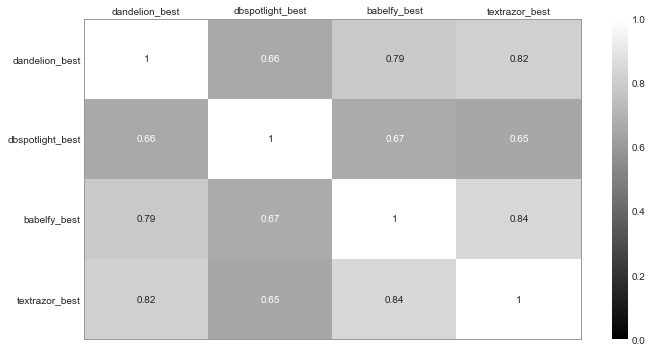

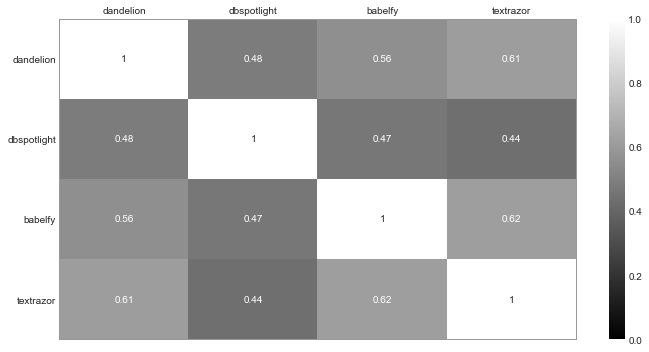

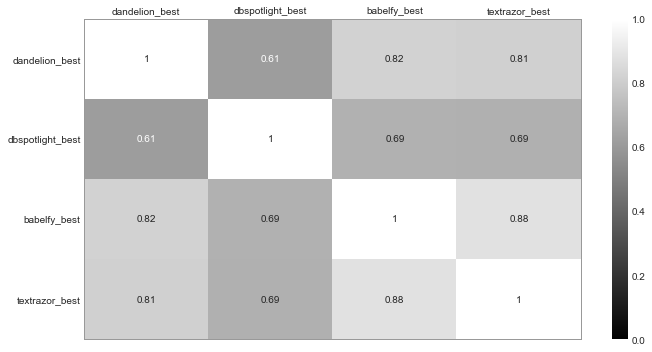

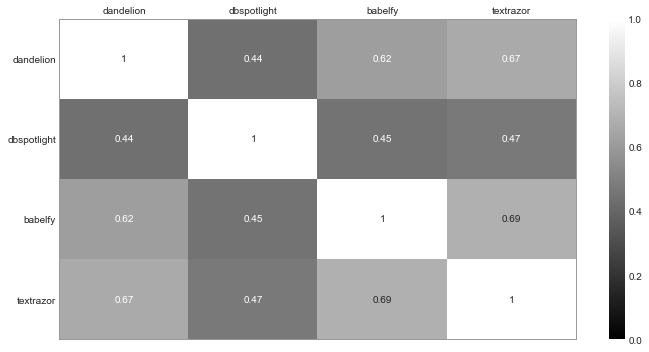

,0_MODEL,accuracy_NN,f1,f1_NN,precision,recall
0,3,0.842000,0.689455,0.871966,0.664804,0.716005
1,4,0.842000,0.689455,0.871966,0.664804,0.716005
2,5,0.867721,0.721332,0.890889,0.771233,0.677497
3,6,0.848400,0.667299,0.874770,0.703333,0.634777
4,7,0.949226,0.833224,0.956604,0.916908,0.763538


,0_MODEL,accuracy_NN,f1,f1_NN,precision,recall
0,3,0.856655,0.668757,0.887399,0.672269,0.665281
1,4,0.856655,0.668757,0.887399,0.672269,0.665281
2,5,0.878498,0.675264,0.903050,0.774194,0.598753
3,6,0.840564,0.588103,0.871765,0.639024,0.544699
4,7,0.930717,0.769415,0.942897,0.904494,0.669439


,3,4,5,6,7,GT,babelfy,dandelion,dbspotlight,textrazor
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,Q1422,NaN,Q847017,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,Q1422,NaN,Q847017,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,Q1422,NaN,Q847017,NaN,NaN
7,NaN,NaN,NaN,Q1422,NaN,Q1422,Q1422,Q1422,Q1422,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,3,4,5,6,7,GT,babelfy,dandelion,dbspotlight,textrazor
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q6497116,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q5132076,Q216507,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q844837,Q844837,Q844837,Q844837,Q844837,Q844837,Q844837,Q844837,Q4614,Q844837
5,Q844837,Q844837,Q844837,Q844837,Q844837,Q844837,Q844837,Q844837,Q4614,Q844837
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Q3431662,Q3431662,Q3431662,Q3431662,Q3431662,Q3431662,Q3431662,Q3431662,NaN,Q3431662


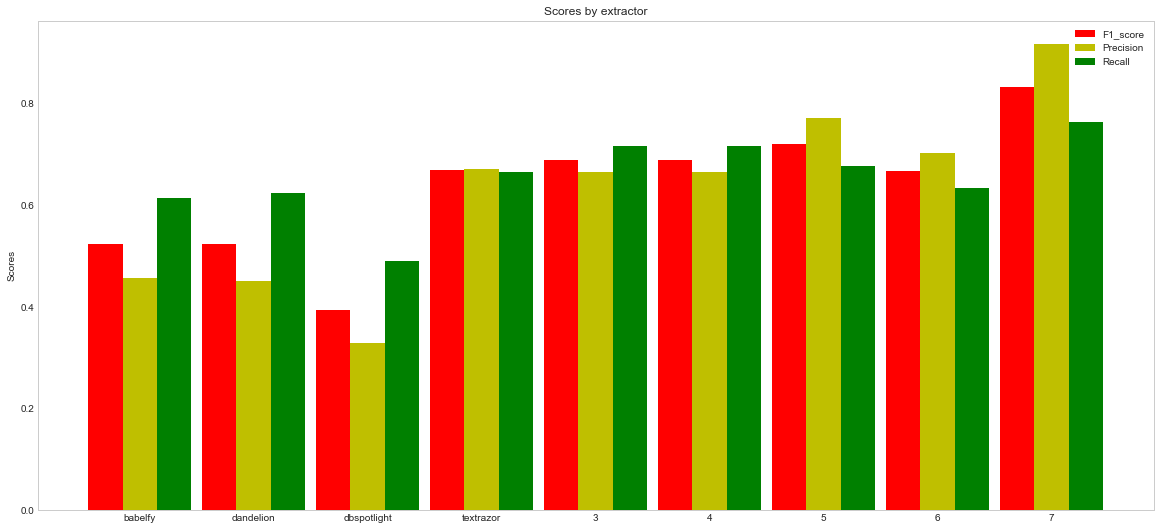

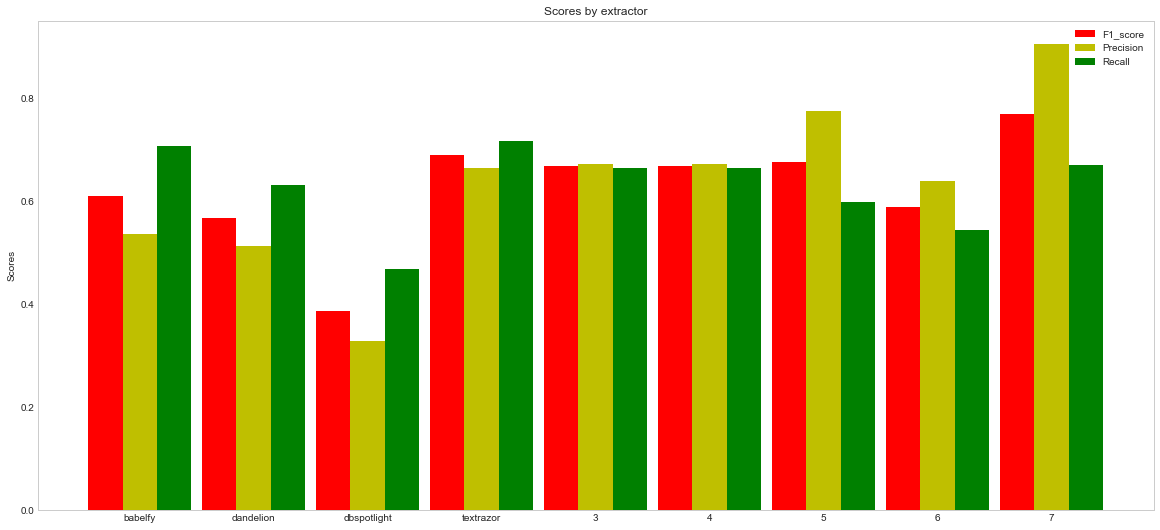

In [624]:
getPlots_and_Results(features_paths_test,features_paths_train,extractors_disambiguation,gt_test_flatten,
                        gt_train_flatten,uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,
                        ['3','4','5','6','7'])

In [13]:
def addExtractorsTypesRepresentation(model_obj,extractors_types):
    candidates_test_iter = iter(model_obj['candidates_test'])
    candidates_train_iter = iter(model_obj['candidates_train'])
    paths_test = model_obj['features_paths_test']
    paths_train = model_obj['features_paths_train']
    model_obj['extractors_types'] = extractors_types
    model_obj['type_dict_test'] = {ext:[] for ext in extractors_types}
    model_obj['type_dict_train'] = {ext:[] for ext in extractors_types}
    for p in paths_test:
        obj = pickle.load(open(p,'rb'))
        features_obj = obj['features']['type']
        flag_g = True
        for ext in extractors_types:
            if flag_g:
                repeats = [len(next(candidates_test_iter)) for line in obj['features']['type'][ext]]
                flag_g = False
            for j,line in enumerate(obj['features']['type'][ext]):
                for k in range(repeats[j]):
                    model_obj['type_dict_test'][ext].append(line)
    
    for p in paths_train:
        obj = pickle.load(open(p,'rb'))
        features_obj = obj['features']['type']
        flag_g = True
        for ext in extractors_types:
            if flag_g:
                repeats = [len(next(candidates_train_iter)) for line in obj['features']['type'][ext]]
                flag_g = False
            for j,line in enumerate(obj['features']['type'][ext]):
                for k in range(repeats[j]):
                    model_obj['type_dict_train'][ext].append(line)
    for ext in extractors_types:
        model_obj['type_dict_test'][ext] = np.array(model_obj['type_dict_test'][ext])
        model_obj['type_dict_train'][ext] = np.array(model_obj['type_dict_train'][ext])
    return model_obj


def generateHistograM(x,path,ext_names):
    N = len(x)
    x = np.transpose(x)
    f1_score = tuple(x[0])
    precision = tuple(x[1])
    recall = tuple(x[2])


    ind = np.arange(N)  # the x locations for the groups
    width = 0.3      # the width of the bars

    fig, ax = plt.subplots(figsize=(20,9))

    rects1 = ax.bar(ind, f1_score, width, color='r')

    rects2 = ax.bar(ind + width, precision, width, color='y')

    rects3 = ax.bar(ind + width*2, recall, width, color='g')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title('Scores by extractor')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(tuple(ext_names+['combination']))

    ax.legend((rects1[0], rects2[0],rects3[0]), ('F1_score', 'Precision','Recall'))
    
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '',
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.savefig(path, dpi=600)
    plt.show()


def getPlots_and_Results(features_paths_test,features_paths_train,extractors_disambiguation,gt_test_flatten,
                        gt_train_flatten,uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,
                        extractors_indexes):
    
    models_path_folder = 'disambiguation_models/'
    
    output_models_extractors = {'test':dict(),'train':dict()}
    records_train = []
    for_hist_train = dict()
    
    for ext in extractors_disambiguation:
        list_ext = getURIListExt(features_paths_train,ext)
        list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
        output_models_extractors['train'][ext] = list_ext_flatten
        scores_disambiguation_obj = getScoresDisambiguation(gt_train_flatten,list_ext_flatten)
        for_hist_train[ext] = scores_disambiguation_obj
        scores_disambiguation_obj['extractor']=ext
        records_train.append(scores_disambiguation_obj)

    df_eval_ext_train=pd.DataFrame(records_train)

    writer = pd.ExcelWriter('disambiguation_images/extracors_scores_train.xlsx')
    df_eval_ext_train.to_excel(writer)
    writer.save()
    display(df_eval_ext_train)
    
    records_test = []
    for_hist_test = dict()
    
    for ext in extractors_disambiguation:
        list_ext = getURIListExt(features_paths_test,ext)
        list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
        output_models_extractors['test'][ext] = list_ext_flatten
        scores_disambiguation_obj = getScoresDisambiguation(gt_test_flatten,list_ext_flatten)
        for_hist_test[ext] = scores_disambiguation_obj
        scores_disambiguation_obj['0_extractor']=ext
        records_test.append(scores_disambiguation_obj)

    df_eval_ext_test=pd.DataFrame(records_test)

    writer = pd.ExcelWriter('disambiguation_images/extracors_scores_test.xlsx')
    df_eval_ext_test.to_excel(writer)
    writer.save()
    display(df_eval_ext_test)
    
    best_result_test = getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)
    print('Max scores test:',getScoresDisambiguation(gt_test_flatten,best_result_test))
    
    best_result_train = getBestResult(uris_list_per_extractor_train_flatten,gt_train_flatten)
    print('Max scores train:',getScoresDisambiguation(gt_train_flatten,best_result_train))
    
    
    ext_obj_rel_test = getRelationshipExtractorDF_obj(uris_list_per_extractor_test_flatten,gt_test_flatten,display_flag=False,
                                                      paths=['disambiguation_images/ext_relathionship_test_1.png',
                                                             'disambiguation_images/ext_relathionship_test_2.png'
                                                            ])
    
    ext_obj_rel_train = getRelationshipExtractorDF_obj(uris_list_per_extractor_train_flatten,gt_train_flatten,display_flag=False,
                                                      paths=['disambiguation_images/ext_relathionship_train_1.png',
                                                             'disambiguation_images/ext_relathionship_train_2.png'
                                                            ])
    
    

    
    records_train = []
    records_test = []
    
    for index in extractors_indexes:
        model_obj = pickle.load(open(models_path_folder+index+'.p','rb'))
        P = model_obj['predicted_test']
        uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
        output_models_extractors['test'][index] = uri_list
        obj = getScoresDisambiguation(gt_test_flatten,uri_list)
        for_hist_train[index] = obj
        obj['0_MODEL']=index
        f1 = f1_score(np.squeeze(model_obj['test_Y']),np.squeeze(P).round())
        acc = accuracy_score(np.squeeze(model_obj['test_Y']),np.squeeze(P).round())
        obj['f1_NN'] = f1
        obj['accuracy_NN'] = acc
        records_test.append(obj)
        
        P = model_obj['predicted_train']
        uri_list =getLISTPREDICTED(P,model_obj['candidates_train'])
        output_models_extractors['train'][index] = uri_list
        obj = getScoresDisambiguation(gt_train_flatten,uri_list)
        for_hist_test[index] = obj
        obj['0_MODEL']=index
        f1 = f1_score(np.squeeze(model_obj['train_Y']),np.squeeze(P).round())
        acc = accuracy_score(np.squeeze(model_obj['train_Y']),np.squeeze(P).round())
        obj['f1_NN'] = f1
        obj['accuracy_NN'] = acc
        records_train.append(obj)
        
    df_eval_ext_train=pd.DataFrame(records_train)

    writer = pd.ExcelWriter('disambiguation_images/models_scores_train.xlsx')
    df_eval_ext_train.to_excel(writer)
    writer.save()
    display(df_eval_ext_train)
    
    df_eval_ext_test=pd.DataFrame(records_test)

    writer = pd.ExcelWriter('disambiguation_images/models_scores_test.xlsx')
    df_eval_ext_test.to_excel(writer)
    writer.save()
    display(df_eval_ext_test)
    
    output_models_extractors['test']['GT'] =  gt_test_flatten
    output_models_extractors['train']['GT'] =  gt_train_flatten
    
    
    for key in output_models_extractors:
        df = pd.DataFrame(output_models_extractors[key])
        writer = pd.ExcelWriter('disambiguation_images/outputs_'+key+'.xlsx')
        df.to_excel(writer)
        writer.save()
        display(df)
        df = df.fillna('0')
        for index in extractors_indexes:
            df_wrong = df[df[index]!=df['GT']]
            writer = pd.ExcelWriter('disambiguation_images/outputs_'+key+'_wrong_'+index+'.xlsx')
            df_wrong.to_excel(writer)
            writer.save()
        
    lables_test = [key for key in for_hist_test]
    x_test = [[for_hist_test[key][sc] for sc in ['f1','precision','recall']] for key in for_hist_test]
    generateHistograM(x_test,'disambiguation_images/hist_test.png',lables_test)
    lables_train = [key for key in for_hist_train]
    x_train= [[for_hist_train[key][sc] for sc in ['f1','precision','recall']] for key in for_hist_train]
    generateHistograM(x_train,'disambiguation_images/hist_train.png',lables_train)

In [547]:
len(model_obj_1['type_dict_train']['textrazor'])

8545

In [535]:
sum([len(i) for i in candidates_train])

8981

In [544]:
len(candidates_train)

5807

In [537]:
sum([len(pickle.load(open(p,'rb'))['uris_list']) for p in features_paths_train])


784

In [540]:
sum([len(pickle.load(open(p,'rb'))['uris_list']['textrazor']) for p in features_paths_train])

5807

In [541]:
sum([len(pickle.load(open(p,'rb'))['features']['type']['textrazor']) for p in features_paths_train])

5807

In [527]:
next(v)

['Q847017', nan]

In [525]:
model_obj = addExtractorsTypesRepresentation(model_obj,extractors_types)

In [497]:
model_obj.keys()

dict_keys(['features_paths_train', 'features_paths_test', 'extractors_disambiguation', 'candidates_train', 'candidates_test', 'train_X', 'train_Y', 'train_GT', 'train_EXT', 'train_GT_best', 'train_Y_best', 'test_X', 'test_Y', 'test_GT', 'test_EXT', 'test_GT_best', 'test_Y_best', 'path', 'history_scores', 'predicted_train', 'predicted_test', 'extractors_types', 'type_dict_test', 'type_dict_train'])

In [455]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=1000, random_state=0, min_samples_leaf=4,n_estimators=20)
clf.fit(X_train,Y_train)

predicted_test = np.transpose([[p[1] for p in p_list] for p_list in clf.predict_proba(X_test)])
print('TEST\n',evaluate_prediction(Y_test,gt_test_flatten,predicted_test,uris_list_per_extractor_test_flatten))

predicted_train = np.transpose([[p[1] for p in p_list] for p_list in clf.predict_proba(X_train)])
print('TRAIN\n',evaluate_prediction(Y_train,gt_train_flatten,predicted_train,uris_list_per_extractor_train_flatten))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


IndexError: invalid index to scalar variable.

In [456]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=1000, random_state=0, min_samples_leaf=4,n_estimators=20)
clf.fit(X_train,Y_train)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [458]:
clf.predict_proba(X_test)[0]

array([ 0.0371776,  0.9628224])

In [472]:
predicted_test = [[p_list[1]] for p_list in clf.predict_proba(X_test)]
#print('TEST\n',evaluate_prediction(Y_test,gt_test_flatten,predicted_test,uris_list_per_extractor_test_flatten))


predicted_train = [[p_list[1]] for p_list in clf.predict_proba(X_train)]
#print('TRAIN\n',evaluate_prediction(Y_train,gt_train_flatten,predicted_train,uris_list_per_extractor_train_flatten))

In [473]:
predicted_test

[[0.9628224017966005],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.052737775109074556],
 [0.83204365749506548],
 [0.052737775109074556],
 [0.83204365749506548],
 [0.052737775109074556],
 [0.83204365749506548],
 [0.17382246980431573],
 [0.65362325810524147],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.10895409355105316],
 [0.059018917242601457],
 [0.73457045772117691],
 [0.9628224017966005],
 [0.092687363098136383],
 [0.73457045772117691],
 [0.17382246980431573],
 [0.65362325810524147],
 [0.17382246980431573],
 [0.65362325810524147],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.9628224017966005],
 [0.052737775109074556],
 [0.83204365749506548],
 [0.092687363098136383],
 [0.73457045772117691],
 [0.9628224017966005],
 [0.98587528301259275],
 [0.19331377671005115],
 [0.98587528301259275],
 [0.19331377671005115],
 [0.9628224017966005],
 [0.9628224017966005],
 [

In [474]:
uri_list =getLISTPREDICTED(predicted_test,model_obj['candidates_test'])
print(getScoresDisambiguation(gt_test_flatten,uri_list))

print(getScoresDisambiguation(gt_test_flatten_best,uri_list))

{'precision': 0.7552083333333334, 'recall': 0.6029106029106029, 'f1': 0.6705202312138728}
{'precision': 0.7552083333333334, 'recall': 0.7286432160804021, 'f1': 0.7416879795396419}


In [225]:
getScoresDisambiguation(gt_test_flatten,getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten))

{'f1': 0.9055745164960182, 'precision': 1.0, 'recall': 0.8274428274428275}

In [ ]:
{'precision': 0.7741935483870968, 'recall': 0.5987525987525988, 'f1': 0.6752637749120751}
{'precision': 0.7741935483870968, 'recall': 0.7236180904522613, 'f1': 0.7480519480519481}

In [ ]:
getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)

In [201]:
clf.predict(X_test) == X_test_predicted.round()

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       ..., 
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]], dtype=bool)

array([[ 0.92193605,  0.92193605,  0.92193605,  0.92193605],
       [ 0.92193605,  0.92193605,  0.92193605,  0.92193605],
       [ 0.92193605,  0.92193605,  0.92193605,  0.92193605],
       ..., 
       [ 0.92193605,  0.92193605,  0.92193605,  0.92193605],
       [ 0.21285273,  0.56072213,  0.56072213,  0.56072213],
       [ 0.92193605,  0.92193605,  0.92193605,  0.92193605]])

0.83899176954732513

In [177]:
clf.score(X_train, Y_train)

0.8308937489237127

In [176]:
clf.score(X_test, Y_test)

0.83899176954732513

In [174]:
for l in Y_test:
    print(l)

[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[1 1 1 0]
[1 1 1 1]
[1 1 1 1]
[1 0 0 1]
[1 1 1 1]
[1 0 0 1]
[0 0 0 1]
[0 0 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 0 1 1]
[0 1 1 0]
[1 1 1 1]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[0 0 0 0]
[0 0 0 0]
[1 1 0 1]
[1 1 1 1]
[1 1 0 0]
[1 1 1 1]
[1 1 1 1]
[1 1 0 0]
[1 1 1 1]
[1 1 1 1]
[1 0 0 1]
[1 0 0 1]
[1 1 1 1]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[1 0 1 0]
[1 0 1 0]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 0 0 1]
[1 0 1 1]
[1 1 1 1]
[0 0 0 0]
[1 1 1 1]
[0 0 0 0]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[0 0 0 1]
[1 1 1 1]
[1 1 1 0]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 0 1]
[1 1 0 1]
[1 1 0 1]
[1 1 0 1]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 0]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[0 0 0 0]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[0 0 0 0]


[1 0 1 0]
[1 0 1 0]
[0 0 0 0]
[0 0 1 0]
[0 0 0 0]
[1 1 1 1]
[1 1 1 0]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[0 0 0 0]
[0 0 1 0]
[1 1 1 1]
[1 1 1 1]
[1 1 0 0]
[1 1 1 1]
[1 0 0 1]
[1 1 1 1]
[1 0 0 0]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 0 1 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[1 1 1 1]
[1 1 1 0]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 0 1 1]
[1 0 1 1]
[1 1 1 1]
[1 1 1 1]
[0 0 1 1]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[1 1 1 1]
[1 1 1 0]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[1 1 1 1]
[0 0 0 0]
[0 1 1 1]
[0 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 0 1 1]
[1 1 0 1]
[0 1 1 1]
[0 1 0 1]
[1 1 1 1]
[1 0 0 1]
[1 0 0 0]
[1 1 1 1]
[1 1 0 1]
[1 1 1 1]
[1 0 1 0]
[1 1 1 1]
[1 1 1 1]
[1 0 1 0]
[0 0 0 0]
[0 0 0 0]
[1 1 1 1]
[1 1 1 1]
[1 1 1 1]
[1 1 1 0]
[1 1 0 1]
[1 1 0 1]
[1 1 1 1]
[0 1 0 0]


In [173]:
for l in clf.predict(X_test):
    print(l)

[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  1.  1.]
[ 1.  0.  1.  1.]
[ 1.  0.  1.  1.]
[ 1.  1.  1.  0.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  0.  1.]
[ 1.  1.  1.  0.]
[ 1.  1.  1.  0.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  1.  1.]
[ 1.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  0.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  0.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  0.  1.]
[ 1.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  1.]
[ 0.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  

[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  1.]
[ 0.  1.  1.  1.]
[ 1.  1.  1.  0.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 0.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  0.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  0.]
[ 1.  1.  1.  1.]
[ 1.  0.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  0.  1.]
[ 1.  1.  1.  0.]
[ 1.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 0.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  

[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  1.  1.]
[ 0.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  0.]
[ 0.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 0.  1.  0.  1.]
[ 0.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  0.  0.  0.]
[ 0.  0.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  0.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 0.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  1.  0.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 1.  1.  0.  1.]
[ 0.  0.  0.  0.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  0.  0.  1.]
[ 1.  0.  

In [75]:
df_eval_train[(df_eval_train['uri_GT']==df_eval_train['uri_babelfy'])&(df_eval_train['count_rights']==1)]

,count_rights,text,type_GT,type_adel,type_alchemy,type_meaning_cloud,type_opencalais,type_textrazor,uri_GT,uri_babelfy,uri_dandelion,uri_dbspotlight,uri_textrazor
337,1,faculty,Q5428874,Role,JobTitle,0,0,0,Q5428874,Q5428874,Q37226,Q180958,0
338,1,member,Q5428874,Role,JobTitle,0,0,0,Q5428874,Q5428874,Q37226,Q486839,0
553,1,comparison,0,0,0,0,0,0,0,0,Q1435712,Q878226,Q16153325
561,1,thinking,0,0,0,0,0,0,0,0,Q9420,Q9420,Q16153325
1212,1,phd,0,0,0,0,0,0,0,0,Q752297,Q752297,Q752297
1371,1,pisa,Q13375,Place,Location,City,Facility,University,Q13375,Q13375,0,Q645663,Q645663
1382,1,marcello,0,Person,Person,FullName,0,Scientist,0,0,Q232583,Q55469,Q3845552
1578,1,levi,Q185007,Person,0,LastName,0,Person,Q185007,Q185007,Q312628,0,0
1579,1,-,Q185007,Person,0,LastName,0,Person,Q185007,Q185007,0,0,0
1605,1,levi,Q185007,Person,0,LastName,0,Person,Q185007,Q185007,Q312628,0,0


In [69]:
df_eval_train[['count_rights','uri_GT',
       'uri_babelfy', 'uri_dandelion', 'uri_dbspotlight', 'uri_textrazor']][]

,count_rights,uri_GT,uri_babelfy,uri_dandelion,uri_dbspotlight,uri_textrazor
0,3,NaN,NaN,NaN,Q6497116,NaN
1,4,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,Q5132076,Q216507,NaN
3,4,NaN,NaN,NaN,NaN,NaN
4,3,Q844837,Q844837,Q844837,Q4614,Q844837
5,3,Q844837,Q844837,Q844837,Q4614,Q844837
6,4,NaN,NaN,NaN,NaN,NaN
7,4,NaN,NaN,NaN,NaN,NaN
8,4,NaN,NaN,NaN,NaN,NaN
9,3,Q3431662,Q3431662,Q3431662,NaN,Q3431662


In [ ]:
getTYPESListPerExtractor

In [35]:
uris_list_per_extractor_train

[[{'babelfy': nan,
   'dandelion': nan,
   'dbspotlight': 'Q6497116',
   'textrazor': nan},
  {'babelfy': nan, 'dandelion': nan, 'dbspotlight': nan, 'textrazor': nan},
  {'babelfy': nan,
   'dandelion': 'Q5132076',
   'dbspotlight': 'Q216507',
   'textrazor': nan},
  {'babelfy': nan, 'dandelion': nan, 'dbspotlight': nan, 'textrazor': nan},
  {'babelfy': 'Q844837',
   'dandelion': 'Q844837',
   'dbspotlight': 'Q4614',
   'textrazor': 'Q844837'},
  {'babelfy': 'Q844837',
   'dandelion': 'Q844837',
   'dbspotlight': 'Q4614',
   'textrazor': 'Q844837'},
  {'babelfy': nan, 'dandelion': nan, 'dbspotlight': nan, 'textrazor': nan},
  {'babelfy': nan, 'dandelion': nan, 'dbspotlight': nan, 'textrazor': nan},
  {'babelfy': nan, 'dandelion': nan, 'dbspotlight': nan, 'textrazor': nan},
  {'babelfy': 'Q3431662',
   'dandelion': 'Q3431662',
   'dbspotlight': nan,
   'textrazor': 'Q3431662'},
  {'babelfy': 'Q3431662',
   'dandelion': 'Q3431662',
   'dbspotlight': nan,
   'textrazor': 'Q3431662'},
  {'

In [ ]:
def getBestResult(uris_list_per_extractor,gt_list):
    best_result = list()
    for i,file in enumerate(gt_list):
        best_result_p = list()
        for j,uri in enumerate(file):
            if True in [uris_list_per_extractor[i][j][key]==uri for key in uris_list_per_extractor[i][j]]:
                best_result_p.append(uri)
            else:
                best_result_p.append(np.NAN)
        best_result.append(best_result_p)
    return best_result

In [102]:
s = '''    model_obj['train_X']= X_train
    model_obj['train_Y']= Y_train
    model_obj['train_GT']= gt_train_flatten
    model_obj['train_EXT']= uris_list_per_extractor_train_flatten'''

print(s.replace('train','test'))

    model_obj['test_X']= X_test
    model_obj['test_Y']= Y_test
    model_obj['test_GT']= gt_test_flatten
    model_obj['test_EXT']= uris_list_per_extractor_test_flatten
